# $\textbf{Overview}$
This document provides instructions on running the JWST Science Calibration Pipeline (referred to as “the pipeline”) and individual pipeline steps specifically for <mark>$\textbf{Time Series Observation (TSO) Imaging with NIRCam NRC_TSIMAGE exposure data}$</mark>.

End-to-end calibration of JWST data is divided into 3 main stages of processing. Multiple pipeline modules are used for different stages of processing and for different JWST observing modes. The modules are broken into the following 3 stages:

- $\textbf{Stage 1}$: Detector-level corrections and ramp fitting for individual exposures

- $\textbf{Stage 2}$: Instrument-mode calibrations for individual exposures

- $\textbf{Stage 3}$: Combining data from multiple exposures within an observation

$\textbf{Stage 1}$ corrections are applied nearly universally for all instruments and modes. $\textbf{Stage 2}$ is divided into separate modules for <mark>$\textbf{imaging}$</mark> and spectroscopic modes. $\textbf{Stage 3}$ is divided into five separate modules for imaging, spectroscopic, coronagraphic, Aperture Masking Interferometry (AMI), and <mark>$\textbf{Time Series Observation (TSO)}$</mark> modes.

# $\textbf{Import Library}$ 

In [2]:
import os
#os.environ['CRDS_PATH'] = '/fenrirdata1/kg_data/crds_cache/' #These pathways should be defined in your ~./bash profile. If not, you can set them within the notebook.
#os.environ['CRDS_SERVER_URL']= 'https://jwst-crds.stsci.edu'
#os.environ['CRDS_CONTEXT']='jwst_0756.pmap' #Occasionally, the JWST CRDS pmap will be updated. Updates may break existing code. Use this command to revert to an older working verison until the issue is fixed. 


import jwst
print(jwst.__version__) #Print what version of the pipeline you are using.

from jwst.pipeline.calwebb_detector1 import Detector1Pipeline #Stage 1
from jwst.pipeline.calwebb_image2 import Image2Pipeline #Stage 2
from jwst.pipeline.calwebb_tso3 import Tso3Pipeline #Stage 3
from jwst.associations.asn_from_list import asn_from_list #Association file imports
from jwst.associations.lib.rules_level2_base import DMSLevel2bBase

#General
from astropy.io import fits, ascii
import matplotlib.pyplot as plt
%matplotlib inline
import csv
import numpy as np
import asdf
import glob
import time
import yaml
from copy import deepcopy

from tshirt.pipeline import phot_pipeline,analysis #tshirt specific imports
from splintegrate import splintegrate

#modeling
import batman
from scipy.optimize import curve_fit

#Style Choice
class style:
   BOLD = '\033[1m'
   END = '\033[0m'

1.3.1


# $\textbf{Stage 1}$
### $\textbf{Detector-level corrections and ramp fitting for individual exposures.}$
Stage 1 consists of detector-level corrections that are performed on a group-by-group basis, followed by ramp fitting.
The output of stage 1 processing is a countrate image per exposure, or per integration for some modes.

#### $\textbf{Detector1Pipeline:}$
Apply all calibration steps to raw JWST ramps to produce a 2-D slope product. This stage takes care of basic data reduction steps, such as reference pixel correction, superbias subtraction, removal of non-linearity, and flagging of cosmic rays. In the final step in this stage of the pipeline, line-fitting is performed on each integration. A slope image is created for each integration. The steps in this stage are identical for all data.

There are two general configurations for this pipeline, depending on whether the data are to be treated as a Time Series Observation (TSO). The configuration is provided by CRDS reference file mappings and are usually set by default to always give access to the most recent reference file deliveries and selection rules. For TSO exposures, <mark>some steps are set to be skipped by default</mark>:

- The <mark>$\textbf{ipc}$</mark> step corrects a JWST exposure for interpixel capacitance by convolving with an IPC reference image.
- The <mark>$\textbf{persistence}$</mark> step. Based on a model, this step computes the number of traps that are expected to have captured or released a charge during an exposure. The released charge is proportional to the persistence signal, and this will be subtracted (group by group) from the science data. 

$\textbf{INPUT FILES:}$
Exposure raw data products are designated by a file name suffix of “uncal.” These files usually contain only the raw detector pixel values from an exposure, with the addition of some table extensions containing various types of meta data associated with the exposure. Additional extensions can be included for certain instruments and readout types. Below are header modifications to the "uncal" fits files. 

In [3]:
#Adding header modifications
all_uncal_files = [] # All Uncalibrated File Names. Also use to check that all files have been modified by the loop. 
BaseDirectory = '/fenrirdata1/kg_data/pipeline_output/WASP80b_WLP4/Raw_Data/'
for fitsName in glob.glob(BaseDirectory + '*nrca3_uncal.fits'): #Grabbing only nrca3 files from the directory
    HDUList = fits.open(fitsName, 'update')
    HDUList[0].header['NOUTPUTS'] = (4, 'Number of output amplifiers') #This was not input at the time of the simulation. Therefore, we manually must input this information. 
    HDUList.close()
    all_uncal_files.append(fitsName)
    
all_uncal_files = sorted(all_uncal_files) #sort files alphabetically. 

In [4]:
seg01_len = len(glob.glob('/fenrirdata1/kg_data/pipeline_output/WASP80b_WLP4/ROEBA/splintegrate/jw01185002001_01101_00001-seg001*.fits'))

In [ ]:
startTime = time.time() #Time how long this step takes

for filename_stage1 in all_uncal_files:
    
    # Instantiate the class. Do not provide a configuration file.
    pipeline_stage1 = Detector1Pipeline()
    
    # Manually set any desired non-default parameter values
    
    # Default is to skip the persistence and IPC correction
    # Make that explicit here
    pipeline_stage1.persistence.skip = True
    pipeline_stage1.ipc.skip = True
    
    pipeline_stage1.refpix.skip = False # Make sure to skip steps appropriate if using an alternate ref pix correction method. Otherwise, the default is 'False'.
    pipeline_stage1.superbias.skip = False 
    
    # The default value for CR flagging is 3 or 4 sigma
    # which tends to be too aggressive and flags noise.
    # Set it to something more reasonable
    #pipeline_stage1.jump.rejection_threshold = 9
    pipeline_stage1.jump.skip=True # Currently we are skipping this step as we are testing the pipeline with this simulation and lots of the data gets flagged. 
    
    # Specify that you want results saved to a file
    pipeline_stage1.save_results = True
    pipeline_stage1.output_dir = '/fenrirdata1/kg_data/pipeline_output/WASP80b_WLP4/'
    
    # Execute the pipeline using the run method
    result_stage1 = pipeline_stage1.run(filename_stage1)
    
executionTime = (time.time() - startTime)
print('Stage 1 Execution Time in Seconds: ' + str(executionTime)) #Time how long this step takes

2021-11-07 23:49:56,593 - stpipe.Detector1Pipeline - INFO - Detector1Pipeline instance created.
2021-11-07 23:49:56,598 - stpipe.Detector1Pipeline.group_scale - INFO - GroupScaleStep instance created.
2021-11-07 23:49:56,603 - stpipe.Detector1Pipeline.dq_init - INFO - DQInitStep instance created.
2021-11-07 23:49:56,607 - stpipe.Detector1Pipeline.saturation - INFO - SaturationStep instance created.
2021-11-07 23:49:56,615 - stpipe.Detector1Pipeline.ipc - INFO - IPCStep instance created.
2021-11-07 23:49:56,619 - stpipe.Detector1Pipeline.superbias - INFO - SuperBiasStep instance created.
2021-11-07 23:49:56,625 - stpipe.Detector1Pipeline.refpix - INFO - RefPixStep instance created.
2021-11-07 23:49:56,630 - stpipe.Detector1Pipeline.rscd - INFO - RscdStep instance created.
2021-11-07 23:49:56,634 - stpipe.Detector1Pipeline.firstframe - INFO - FirstFrameStep instance created.
2021-11-07 23:49:56,639 - stpipe.Detector1Pipeline.lastframe - INFO - LastFrameStep instance created.
2021-11-07 2

2021-11-07 23:50:05,837 - stpipe.Detector1Pipeline - INFO - Prefetch for REFPIX reference file is 'N/A'.
2021-11-07 23:50:05,838 - stpipe.Detector1Pipeline - INFO - Prefetch for RESET reference file is 'N/A'.
2021-11-07 23:50:05,840 - stpipe.Detector1Pipeline - INFO - Prefetch for RSCD reference file is 'N/A'.
2021-11-07 23:50:05,841 - stpipe.Detector1Pipeline - INFO - Prefetch for SATURATION reference file is '/fenrirdata1/kg_data/crds_cache/references/jwst/nircam/jwst_nircam_saturation_0067.fits'.
2021-11-07 23:50:05,843 - stpipe.Detector1Pipeline - INFO - Prefetch for SUPERBIAS reference file is '/fenrirdata1/kg_data/crds_cache/references/jwst/nircam/jwst_nircam_superbias_0027.fits'.
2021-11-07 23:50:05,846 - stpipe.Detector1Pipeline - INFO - Starting calwebb_detector1 ...
2021-11-07 23:50:10,058 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale running with args (<RampModel(212, 6, 256, 2048) from jw01185002001_01101_00001-seg001_nrca3_uncal.fits>,).
2021-11-07 23:50

$\textbf{OUTPUT FILES:}$ Output files are \*rateints.fits. The pipeline creates a rate.fits and a rateint.fits files in cases where there is more than one integration in a file, but only a rate.fits file in the case where there is only one integration in a file.

In [5]:
all_rateints_files = [] # All Rateints File Names. Also used to check that all the rateints file exist.  
BaseDirectory = '/fenrirdata1/kg_data/pipeline_output/WASP80b_WLP4/'
for fitsName in glob.glob(BaseDirectory + '*nrca3_rateints.fits'): #Grabbing only nrca3 files from the directory
    all_rateints_files.append(fitsName)

### $\textbf{Confirming a Source}$
Plotting one of the rateints.fits files to check that a target source is present before moving on to stage 2 and stage 3. 

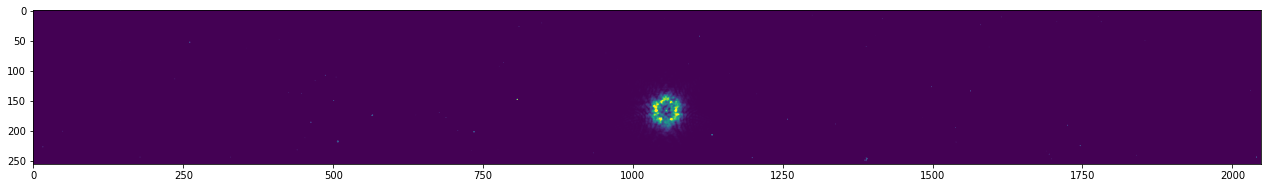

In [6]:
#A check to ensure the star is in the file
file = '/fenrirdata1/kg_data/pipeline_output/WASP80b_WLP4/jw01185002001_01101_00001-seg002_nrca3_rateints.fits' #random file from the rateints list
HDUList = fits.open(file)
#HDUList.info()

image2D = HDUList[1].data[0]
image2D.shape

fig, ax = plt.subplots(figsize=(22,5))
ax.imshow(image2D, vmin=0, vmax=500)
#ax.plot(image2D[32,:])
#ax.set_xlim(900,1000)


#### $\textbf{Split the Integrations for tshirt (referenced later)}$

In [14]:
#splitegrate
#Splintegrate splits and combines integrations from the pipeline up.
#Set flipToDet = False to not flip the x-axis
#This is a step required if running tshirt

#This simulation has multiple segments that need to be split for tshirt purposes.
BaseDirectory = '/fenrirdata1/kg_data/pipeline_output/WASP80b_WLP4/'
for rateints_segment in glob.glob(BaseDirectory + '*nrca3_rateints.fits'): #Grabbing only nrca3 files from the directory
    outDir = '/fenrirdata1/kg_data/pipeline_output/WASP80b_WLP4/splintegrate/'
    splint = splintegrate.splint(inFile=rateints_segment,outDir=outDir,flipToDet=False)
    splint.split()

100%|█████████████████████████████████████████| 167/167 [00:03<00:00, 55.13it/s]


## $\textbf{Association Files}$
#### $\textbf{Organizing the Detector1Pipeline Output Files}$
Associations are basically just lists of things, mostly exposures, that are somehow related. An association file is a JSON-format file that contains a list of all the files with the same instrument set-up (filter, observation mode, etc) that might be combined into a single image. Relationships between multiple exposures are captured in an association, which is a means of identifying a set of exposures that belong together and may be dependent upon one another. The association concept permits exposures to be calibrated, archived, retrieved, and reprocessed as a set rather than as individual objects.

In [7]:
asn_dir = '/fenrirdata1/kg_data/pipeline_output/WASP80b_WLP4/' #Name the association file's directory. 
level2_asn = (os.path.join(asn_dir, 'nrca3_level2_asn.json')) #Name the stage 2 association file and give it a path. 
asn_stage2 = asn_from_list(all_rateints_files,rule=DMSLevel2bBase) #The rateints files; DMSLevel2bBase indicates that a Level2 association is to be created.
with open(level2_asn, 'w') as fh: #Write an association file. 
   fh.write(asn_stage2.dump()[1])

# $\textbf{Stage 2}$
### $\textbf{Processes JWST imaging-mode slope data from Level-2a to Level-2b.}$
Stage 2 processing consists of additional instrument-level and observing-mode corrections and calibrations to produce fully calibrated exposures. The details differ for imaging and spectroscopic exposures, and there are some corrections that are unique to certain instruments or modes. 

#### $\textbf{Image2Pipeline:}$
Imaging processing applies additional instrumental corrections and calibrations that result in a fully calibrated individual exposure. Imaging TSO data are run through this pipeline. The steps are very similar to those in Spec2Pipeline. WCS information is added, flat fielding and flux calibration are performed, and astrometric distortion is removed from the images. There are two parameter references used to control this pipeline, depending on whether the data are to be treated as Time Series Observation (TSO). The parameter reference is provided by CRDS. For TSO exposures, some steps are set to be skipped by default.

$\textbf{INPUT FILES:}$
The input to Image2Pipeline is a countrate exposure, in the form of either “_rate” or “_rateints” data. A single input file can be processed or an ASN file listing multiple inputs can be used, in which case the processing steps will be applied to each input exposure, one at a time. If “_rateints” products are used as input, each step applies its algorithm to each integration in the exposure, where appropriate.

In [16]:
#The file to use is the stage 2 association file defined above. 

# Instantiate the class. Do not provide a configuration file.
pipeline_stage2 = Image2Pipeline()

# Specify that you want results saved to a file
pipeline_stage2.save_results = True
pipeline_stage2.output_dir = '/fenrirdata1/kg_data/pipeline_output/WASP80b_WLP4/'

# Execute the pipeline using the run method
result_stage2 = pipeline_stage2.run(level2_asn)

2021-11-08 15:17:51,522 - stpipe.Image2Pipeline - INFO - Image2Pipeline instance created.
2021-11-08 15:17:51,527 - stpipe.Image2Pipeline.bkg_subtract - INFO - BackgroundStep instance created.
2021-11-08 15:17:51,535 - stpipe.Image2Pipeline.assign_wcs - INFO - AssignWcsStep instance created.
2021-11-08 15:17:51,540 - stpipe.Image2Pipeline.flat_field - INFO - FlatFieldStep instance created.
2021-11-08 15:17:51,546 - stpipe.Image2Pipeline.photom - INFO - PhotomStep instance created.
2021-11-08 15:17:51,552 - stpipe.Image2Pipeline.resample - INFO - ResampleStep instance created.
2021-11-08 15:17:51,868 - stpipe.Image2Pipeline - INFO - Step Image2Pipeline running with args ('/fenrirdata1/kg_data/pipeline_output/WASP80b_WLP4/nrca3_level2_asn.json',).
2021-11-08 15:17:51,879 - stpipe.Image2Pipeline - INFO - Step Image2Pipeline parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': '/fenrirdata1/kg_data/pipeline_output/WASP80b_WLP4/', 'output_ext': '.fits', 'ou

2021-11-08 15:17:57,372 - stpipe.Image2Pipeline.assign_wcs - INFO - Update S_REGION to POLYGON ICRS  303.167993587 -2.153610501 303.170148795 -2.152952750 303.164948000 -2.135825260 303.162770767 -2.136454088
2021-11-08 15:17:57,374 - stpipe.Image2Pipeline.assign_wcs - INFO - assign_wcs updated S_REGION to POLYGON ICRS  303.167993587 -2.153610501 303.170148795 -2.152952750 303.164948000 -2.135825260 303.162770767 -2.136454088
2021-11-08 15:17:57,375 - stpipe.Image2Pipeline.assign_wcs - INFO - COMPLETED assign_wcs
2021-11-08 15:17:57,524 - stpipe.Image2Pipeline.assign_wcs - INFO - Step assign_wcs done
2021-11-08 15:17:57,796 - stpipe.Image2Pipeline.flat_field - INFO - Step flat_field running with args (<CubeModel(212, 256, 2048) from jw01185002001_01101_00001-seg001_nrca3_rateints.fits>,).
2021-11-08 15:17:57,799 - stpipe.Image2Pipeline.flat_field - INFO - Step flat_field parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 

2021-11-08 15:18:18,849 - stpipe.Image2Pipeline.photom - INFO - Step photom done
2021-11-08 15:18:18,851 - stpipe.Image2Pipeline - INFO - Finished processing product /fenrirdata1/kg_data/pipeline_output/WASP80b_WLP4/jw01185002001_01101_00001-seg002_nrca3
2021-11-08 15:18:18,853 - stpipe.Image2Pipeline - INFO - Processing product /fenrirdata1/kg_data/pipeline_output/WASP80b_WLP4/jw01185002001_01101_00001-seg003_nrca3
2021-11-08 15:18:18,854 - stpipe.Image2Pipeline - INFO - Working on input /fenrirdata1/kg_data/pipeline_output/WASP80b_WLP4/jw01185002001_01101_00001-seg003_nrca3_rateints.fits ...
2021-11-08 15:18:20,733 - stpipe.Image2Pipeline.assign_wcs - INFO - Step assign_wcs running with args (<CubeModel(212, 256, 2048) from jw01185002001_01101_00001-seg003_nrca3_rateints.fits>,).
2021-11-08 15:18:20,736 - stpipe.Image2Pipeline.assign_wcs - INFO - Step assign_wcs parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output

2021-11-08 15:18:35,591 - stpipe.Image2Pipeline.flat_field - INFO - Extracting matching subarray from flat
2021-11-08 15:18:38,707 - stpipe.Image2Pipeline.flat_field - INFO - Step flat_field done
2021-11-08 15:18:38,887 - stpipe.Image2Pipeline.photom - INFO - Step photom running with args (<CubeModel(212, 256, 2048) from jw01185002001_01101_00001-seg004_nrca3_rateints.fits>,).
2021-11-08 15:18:38,889 - stpipe.Image2Pipeline.photom - INFO - Step photom parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'photom', 'search_output_file': True, 'input_dir': '/fenrirdata1/kg_data/pipeline_output/WASP80b_WLP4', 'inverse': False, 'source_type': None}
2021-11-08 15:18:38,953 - stpipe.Image2Pipeline.photom - INFO - Using photom reference file: /fenrirdata1/kg_data/crds_cache/references/jwst/nircam/jwst_nircam_photom_0093.fits
2021-11

2021-11-08 15:18:55,137 - stpipe.Image2Pipeline.assign_wcs - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/gwcs/utils.py:72: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  indx = np.asarray(np.floor(np.asarray(value) + 0.5), dtype=np.int)

2021-11-08 15:18:55,147 - stpipe.Image2Pipeline.assign_wcs - INFO - Update S_REGION to POLYGON ICRS  303.167993587 -2.153610501 303.170148795 -2.152952750 303.164948000 -2.135825260 303.162770767 -2.136454088
2021-11-08 15:18:55,148 - stpipe.Image2Pipeline.assign_wcs - INFO - ass

$\textbf{OUTPUT FILES:}$ The output is a fully calibrated, but unrectified, exposure, using the product type suffix “_cal” or “_calints”, depending on the type of input.

In [8]:
all_calints_files = [] # All Calibrated Data File Names. Also used to check that all the calints files exist.  
BaseDirectory = '/fenrirdata1/kg_data/pipeline_output/WASP80b_WLP4/'
for fitsName in glob.glob(BaseDirectory + '*nrca3_calints.fits'): #Grabbing only nrca3 files from the directory
    HDUList = fits.open(fitsName, 'update')
    HDUList[1].header['XREF_SCI'] = (1056.75, 'Aperture X reference point in SCI frame') #Fix x-position centering
    HDUList[1].header['YREF_SCI'] = (167.5, 'Aperture Y reference point in SCI frame') #Fix the y-position centering
    HDUList.close()
    all_calints_files.append(fitsName)
all_calints_files = sorted(all_calints_files) #sort files alphabetically. 

In [9]:
#Generate an association file required for stage 3
asn_dir = '/fenrirdata1/kg_data/pipeline_output/WASP80b_WLP4/' #Name the association file's directory. 
level3_asn = (os.path.join(asn_dir, 'nrca3_level3_asn.json')) #Name the stage 3 association file and give it a path.
asn_stage3 = asn_from_list(all_calints_files, product_name ='WASP80b_WLP4_nrca3_level3_asn') #The rateints files; Name the output..
with open(level3_asn, 'w') as fh: #Write an association file. 
   fh.write(asn_stage3.dump()[1])

# $\textbf{Stage 3}$
### $\textbf{Applies level 3 processing to TSO-mode data from}$
Stage 3 processing consists of routines that work with multiple exposures and in most cases produce some kind of combined product. There are unique pipeline modules for stage 3 processing of imaging, spectroscopic, coronagraphic, AMI, and TSO observations. 

#### $\textbf{Tso3Pipeline:}$
The Stage 3 TSO pipeline is to be applied to associations of calibrated TSO exposures (e.g. NIRCam TS imaging, NIRCam TS grism, NIRISS SOSS, NIRSpec BrightObj, MIRI LRS Slitless) and is used to produce calibrated time-series photometry or spectra of the source object. This is a pipeline customized for TSO data. Grism TSO data undergo outlier detection (essentially a check for any cosmic rays/transient effects that were missed in Detector1Pipeline), background subtraction, spectral extraction, and photometry. Imaging TSO data are run through outlier detection, and photometry is performed.

The logic that decides whether to apply the imaging or spectroscopy steps is based on the EXP_TYPE and TSOVISIT keyword values of the input data. Imaging steps are applied if either of the following is true:

- <mark>EXP_TYPE = ‘NRC_TSIMAGE’</mark>

- EXP_TYPE = ‘MIR_IMAGE’ and TSOVISIT = True

$\textbf{INPUT FILES:}$
The spectroscopy steps will be applied in all other cases.
The input to calwebb_tso3 is in the form of an ASN file that lists multiple exposures or exposure segments of a science target. The individual inputs should be in the form of 3D calibrated (“_calints”) products from either calwebb_image2 or calwebb_spec2 processing. 

In [16]:
#The file to use is the stage 3 association file defined above. 

# Instantiate the class. Do not provide a configuration file.
pipeline_stage3 = Tso3Pipeline()

pipeline_stage3.outlier_detection.skip = True

# Specify that you want results saved to a file
pipeline_stage3.save_results = True
pipeline_stage3.output_dir = '/fenrirdata1/kg_data/pipeline_output/WASP80b_WLP4/'

# Execute the pipeline using the run method
result_stage3 = pipeline_stage3.run(level3_asn)

2021-11-08 22:38:22,909 - stpipe.Tso3Pipeline - INFO - Tso3Pipeline instance created.
2021-11-08 22:38:22,916 - stpipe.Tso3Pipeline.outlier_detection - INFO - OutlierDetectionStep instance created.
2021-11-08 22:38:22,922 - stpipe.Tso3Pipeline.tso_photometry - INFO - TSOPhotometryStep instance created.
2021-11-08 22:38:22,928 - stpipe.Tso3Pipeline.extract_1d - INFO - Extract1dStep instance created.
2021-11-08 22:38:22,933 - stpipe.Tso3Pipeline.white_light - INFO - WhiteLightStep instance created.
2021-11-08 22:38:23,103 - stpipe.Tso3Pipeline - INFO - Step Tso3Pipeline running with args ('/fenrirdata1/kg_data/pipeline_output/WASP80b_WLP4/nrca3_level3_asn.json',).
2021-11-08 22:38:23,113 - stpipe.Tso3Pipeline - INFO - Step Tso3Pipeline parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': '/fenrirdata1/kg_data/pipeline_output/WASP80b_WLP4/', 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 's

2021-11-08 22:40:34,215 - stpipe.Tso3Pipeline.outlier_detection - INFO - Step outlier_detection parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': 'outlier_detection', 'search_output_file': False, 'input_dir': '/fenrirdata1/kg_data/pipeline_output/WASP80b_WLP4', 'weight_type': 'ivm', 'pixfrac': 1.0, 'kernel': 'square', 'fillval': 'INDEF', 'nlow': 0, 'nhigh': 0, 'maskpt': 0.7, 'grow': 1, 'snr': '5.0 4.0', 'scale': '1.2 0.7', 'backg': 0.0, 'save_intermediate_results': False, 'resample_data': True, 'good_bits': '~DO_NOT_USE', 'scale_detection': False, 'allowed_memory': None}
2021-11-08 22:40:34,216 - stpipe.Tso3Pipeline.outlier_detection - INFO - Step skipped.
2021-11-08 22:40:34,337 - stpipe.Tso3Pipeline.outlier_detection - INFO - Step outlier_detection done
2021-11-08 22:40:50,690 - stpipe.Tso3Pipeline - INFO - Performing ou

$\textbf{OUTPUT FILES:}$ For imaging TS observations, the tso_photometry step produces a source catalog containing photometry results from all of the “_crfints” products, organized as a function of integration time stamps. This file is saved in ASCII “ecsv” format, with a product type of “_phot.” The file naming is source-based, using the output product name specified in the ASN file.

# <mark>$\textbf{Plotting Results: Unaltered}$</mark>
Initial pipeline results without altering the aperture sizes. In this particular simulation, there is an edge effect (the observation is cut off on the top and bottom). We want to see how observations that turn out this way in real life can effect the results the pipline returns. 

TSOPHOT reference files are ASDF format. An object called ‘radii’ in a TSOPHOT file defines the radii that the step needs. This object is a list of one or more dictionaries. Each such dictionary has four keys: ‘pupil’, ‘radius’, ‘radius_inner’, and ‘radius_outer’. The particular one of these dictionaries to use is selected by comparing meta.instrument.pupil with the value corresponding to ‘pupil’ in each dictionary. If an exact match is found, that dictionary will be used. If no match is found, the first dictionary with ‘pupil’: ‘ANY’ will be selected. The radii will be taken from the values of keys ‘radius’, ‘radius_inner’, and ‘radius_outer’.

The original radii parameters are: 

`radii': [{'pupil': 'WLP8',
   'radius': 50.0,
   'radius_inner': 60.0,
   'radius_outer': 70.0},
  {'pupil': 'ANY', 'radius': 3.0, 'radius_inner': 4.0, 'radius_outer': 5.0}]}`

In [10]:
#Print the stage 3 result file with all the data
with open('/fenrirdata1/kg_data/pipeline_output/WASP80b_WLP4/WASP80b_WLP4_nrca3_level3_asn_phot.ecsv', 'r') as file:
    reader = csv.reader(file)
    for row in reader:
        print(row)

['# %ECSV 0.9']
['# ---']
['# datatype:']
['# - {name: MJD', ' datatype: float64}']
['# - {name: aperture_sum', ' unit: Jy', ' datatype: float64}']
['# - {name: aperture_sum_err', ' unit: Jy', ' datatype: float64}']
['# - {name: annulus_sum', ' unit: Jy', ' datatype: float64}']
['# - {name: annulus_sum_err', ' unit: Jy', ' datatype: float64}']
['# - {name: annulus_mean', ' unit: Jy', ' datatype: float64}']
['# - {name: annulus_mean_err', ' unit: Jy', ' datatype: float64}']
['# - {name: aperture_bkg', ' unit: Jy', ' datatype: float64}']
['# - {name: aperture_bkg_err', ' unit: Jy', ' datatype: float64}']
['# - {name: net_aperture_sum', ' unit: Jy', ' datatype: float64}']
['# - {name: net_aperture_sum_err', ' unit: Jy', ' datatype: float64}']
['# meta: !!omap']
['# - {instrument: NIRCAM}']
['# - {detector: NRCA3}']
['# - {channel: SHORT}']
['# - {subarray: SUBGRISM256}']
['# - {filter: WLP4}']
['# - {pupil: CLEAR}']
['# - {target_name: UNKNOWN}']
['# - {xcenter: 1055.75}']
['# - {ycenter:

['59852.355638380905 0.002483162180569806 6.476243752678415e-06 0.001138143777340683 4.144979995453537e-06 4.025360180290027e-05 1.465986789541005e-07 0.001138143777340683 4.144979995453537e-06 0.0013450184032291232 7.689121686305674e-06']
['59852.35584100787 0.002483590924464001 6.473029452408669e-06 0.0011458177114197928 4.148523512236023e-06 4.052501170104508e-05 1.4672400522340312e-07 0.0011458177114197928 4.148523512236023e-06 0.0013377732130442081 7.688326061199875e-06']
['59852.356043634834 0.002488372419350642 6.4769915328580225e-06 0.0011475803566044418 4.14878135299977e-06 4.058735252194598e-05 1.4673312447497666e-07 0.0011475803566044418 4.14878135299977e-06 0.0013407920627462 7.691801221541876e-06']
['59852.35624626181 0.002497325266881736 6.484092648205724e-06 0.0011378174671310423 4.143924991626964e-06 4.024206094004568e-05 1.465613658265494e-07 0.0011378174671310423 4.143924991626964e-06 0.0013595077997506934 7.69516548273954e-06']
['59852.35644888877 0.00249197724184016

Pipeline Calculated Net Aperture Sum MAD (ppm): 4900.707483425411
Pipeline Calculated Net Aperture Sum std (ppm): 5291.520117183534
Median Relative Error Net Aperture Sum (ppm): 5656.9060264742375
Pipeline Calculated Aperture Background std (ppm): 2506.350234570066
Median Relative Errors Aperture Background (ppm): 3589.0441588527256
Pipeline Calculated Annulus Mean std (ppm): 2506.350234570014
Median Relative Errors Annulus Mean (ppm): 3589.0441588527256
Pipeline Calculated Annulus Sum std (ppm): 2506.350234570066
Median Relative Errors Annulus Sum (ppm): 3589.0441588527256


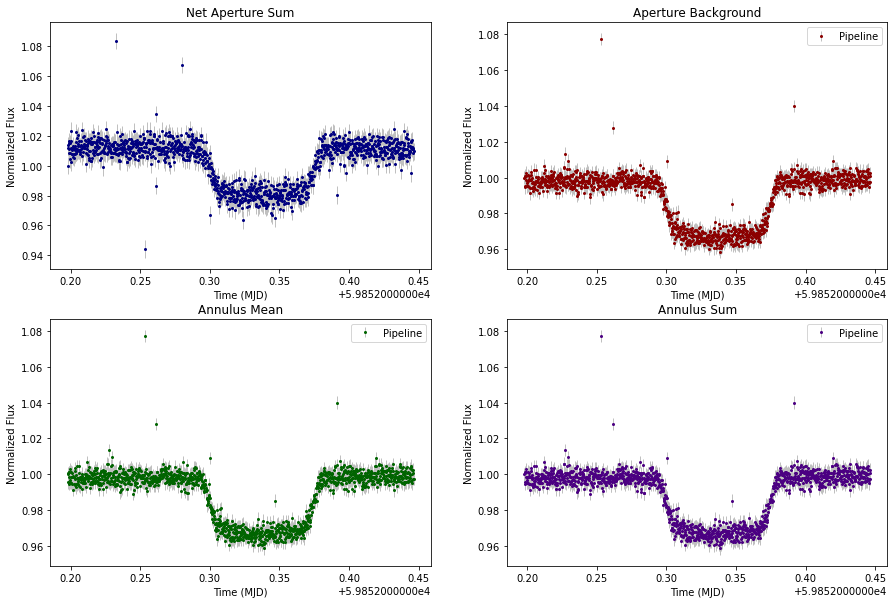

In [11]:
fig, axs = plt.subplots(2, 2,figsize=(15,10))

#JWST pipeline: net aperture
dat = ascii.read('/fenrirdata1/kg_data/pipeline_output/WASP80b_WLP4/WASP80b_WLP4_nrca3_level3_asn_phot.ecsv') #call the data 
normalized_net_aperture_sum_pipeline = dat['net_aperture_sum'].value/dat['net_aperture_sum'][0].value #normalized net aperture sum
std_net_aperture_sum_pipeline = np.std(normalized_net_aperture_sum_pipeline[0:20]) #calculated standard deviation
relative_error_net_aperture_sum_pipeline = (dat['net_aperture_sum_err'].value/dat['net_aperture_sum'].value)

#MAD: 
deviation = normalized_net_aperture_sum_pipeline[0:seg01_len] - np.median(normalized_net_aperture_sum_pipeline[0:seg01_len])
mad = np.median(np.abs(deviation))*1.48

print(style.BOLD+"Pipeline Calculated Net Aperture Sum MAD (ppm):"+style.END + " " +str(mad*10**6))
print(style.BOLD+"Pipeline Calculated Net Aperture Sum std (ppm):"+style.END + " " +str(std_net_aperture_sum_pipeline*10**6))
print(style.BOLD+"Median Relative Error Net Aperture Sum (ppm):"+style.END + " " +str(np.median(relative_error_net_aperture_sum_pipeline)*10**6)) #ppm

axs[0,0].errorbar(dat['MJD'],normalized_net_aperture_sum_pipeline,yerr=relative_error_net_aperture_sum_pipeline,color='navy',fmt='.',markersize=4,elinewidth=1,ecolor='silver',label='Pipeline')
axs[0,0].set_title("Net Aperture Sum")
axs[0,0].set_xlabel("Time (MJD)")
axs[0,0].set_ylabel("Normalized Flux")

#JWST pipeline: aperature background
normalized_aperture__bkg_pipeline = dat['aperture_bkg'].value/dat['aperture_bkg'][0].value #normalized aperture bkg
std_aperture_bkg_pipeline = np.std(normalized_aperture__bkg_pipeline[0:20]) #calculated standard deviation
relative_error_aperture_bkg_pipeline = (dat['aperture_bkg_err'].value/dat['aperture_bkg'].value)

print(style.BOLD+"Pipeline Calculated Aperture Background std (ppm):"+style.END + " " +str(std_aperture_bkg_pipeline*10**6))
print(style.BOLD+"Median Relative Errors Aperture Background (ppm):"+style.END + " " +str(np.median(relative_error_aperture_bkg_pipeline)*10**6))

axs[0,1].errorbar(dat['MJD'],normalized_aperture__bkg_pipeline,yerr=relative_error_aperture_bkg_pipeline,color='darkred',fmt='.',markersize=4,elinewidth=1,ecolor='silver',label='Pipeline')
axs[0,1].set_title("Aperture Background")
axs[0,1].set_xlabel("Time (MJD)")
axs[0,1].set_ylabel("Normalized Flux")
axs[0,1].legend()


#JWST pipeline: annulus mean
normalized_annulus_mean_pipeline = dat['annulus_mean'].value/dat['annulus_mean'][0].value #normalized annulus mean
std_annulus_mean_pipeline = np.std(normalized_annulus_mean_pipeline[0:20]) #calculated standard deviation
relative_error_annulus_mean_pipeline = (dat['annulus_mean_err'].value/dat['annulus_mean'].value)

print(style.BOLD+"Pipeline Calculated Annulus Mean std (ppm):"+style.END + " " +str(std_annulus_mean_pipeline*10**6))
print(style.BOLD+"Median Relative Errors Annulus Mean (ppm):"+style.END + " " +str(np.median(relative_error_annulus_mean_pipeline)*10**6))

axs[1,0].errorbar(dat['MJD'],normalized_annulus_mean_pipeline,yerr=relative_error_annulus_mean_pipeline,color ='darkgreen',fmt='.',markersize=4,elinewidth=1,ecolor='silver',label='Pipeline')
axs[1,0].set_title("Annulus Mean")
axs[1,0].set_xlabel("Time (MJD)")
axs[1,0].set_ylabel("Normalized Flux")
axs[1,0].legend()

#JWST pipeline: annulus sum
normalized_annulus_sum_pipeline = dat['annulus_sum'].value/dat['annulus_sum'][0].value #normalized annulus sum
std_annulus_sum_pipeline = np.std(normalized_annulus_sum_pipeline[0:20]) #calculated standard deviation
relative_error_annulus_sum_pipeline = (dat['annulus_sum_err'].value/dat['annulus_sum'].value)

print(style.BOLD+"Pipeline Calculated Annulus Sum std (ppm):"+style.END + " " +str(std_annulus_sum_pipeline*10**6))
print(style.BOLD+"Median Relative Errors Annulus Sum (ppm):"+style.END + " " +str(np.median(relative_error_annulus_sum_pipeline)*10**6))

axs[1,1].errorbar(dat['MJD'],normalized_annulus_sum_pipeline,yerr=relative_error_annulus_sum_pipeline,color = 'indigo',fmt='.',markersize=4,elinewidth=1,ecolor='silver',label='Pipeline')
axs[1,1].set_title("Annulus Sum")
axs[1,1].set_xlabel("Time (MJD)")
axs[1,1].set_ylabel("Normalized Flux")
axs[1,1].legend()

#### $\textbf{External method: tshirt}$

From: https://tshirt.readthedocs.io/en/latest/phot_pipeline/phot_pipeline.html

The Time Series Helper & Integration Reduction Tool (tshirt) is a general-purpose tool for time series science. Its main application is transiting exoplanet science. tshirt can:

Reduce raw data: flat field, bias subtract, gain correct, etc. Extract Spectroscopy and in our interest extract photometry. This photometric pipeline will take image data that have been reduced (using the JWST pipeline method) and calculate lightcurves on the stars/sources in the field. Therefore, we can use this external method and bypass stage2 & 3 of the JWST Science Calibration Pipeline.

NOTE: yaml file values used in tshirt are pulled from jwst pipeline header information as well as the jwst pipeline stage 3 results. [e.g. `refStarPos` in yaml is pulled from the stage3 results: `xcenter`,`ycenter` values]. Currently, tshirt is using the adjusted centered positions. tshirt is also utlizing the colrow background subtraction method for comparison with the pipelines mean method. 

In [12]:
#read in yaml parameter file, a file required to run tshirt

with open("/fenrirdata1/kg_data/pipeline_output/WASP80b_WLP4/WASP80b_WLP4_NRCA3_phot_pipeline.yaml", "r") as stream:
    paramfile = yaml.safe_load(stream)

paramfile

{'procFiles': '/fenrirdata1/kg_data/pipeline_output/WASP80b_WLP4/splintegrate/jw01185002001_01101_00001-seg*.fits',
 'excludeList': None,
 'srcName': 'WASP80b_WLP4_NRCA3',
 'srcNameShort': 'NRCA3_WASP80b',
 'nightName': 'NRCA3_WASP80b_2022_09_30',
 'refStarPos': [[1056.75, 167.5]],
 'refPhotCentering': None,
 'copyCentroidFile': None,
 'srcGeometry': 'Circular',
 'bkgSub': True,
 'bkgGeometry': 'CircularAnnulus',
 'bkgMethod': 'colrow',
 'apRadius': 3,
 'apHeight': None,
 'apWidth': None,
 'backStart': 4,
 'backEnd': 5,
 'backHeight': None,
 'backWidth': None,
 'backOffset': [0.0, 0.0],
 'boxFindSize': 5,
 'jdRef': 2459832,
 'timingMethod': 'JWSTint',
 'scaleAperture': False,
 'apScale': 2.5,
 'apRange': [2, 17],
 'isCube': False,
 'cubePlane': 0,
 'doCentering': True,
 'FITSextension': 0,
 'HEADextension': 0,
 'isSlope': True,
 'subpixelMethod': 'exact',
 'readNoise': 16.2,
 'detectorGain': 2.05,
 'dateFormat': 'Two Part',
 'diagnosticMode': False,
 'bkgOrderX': 0,
 'bkgOrderY': 0,
 '

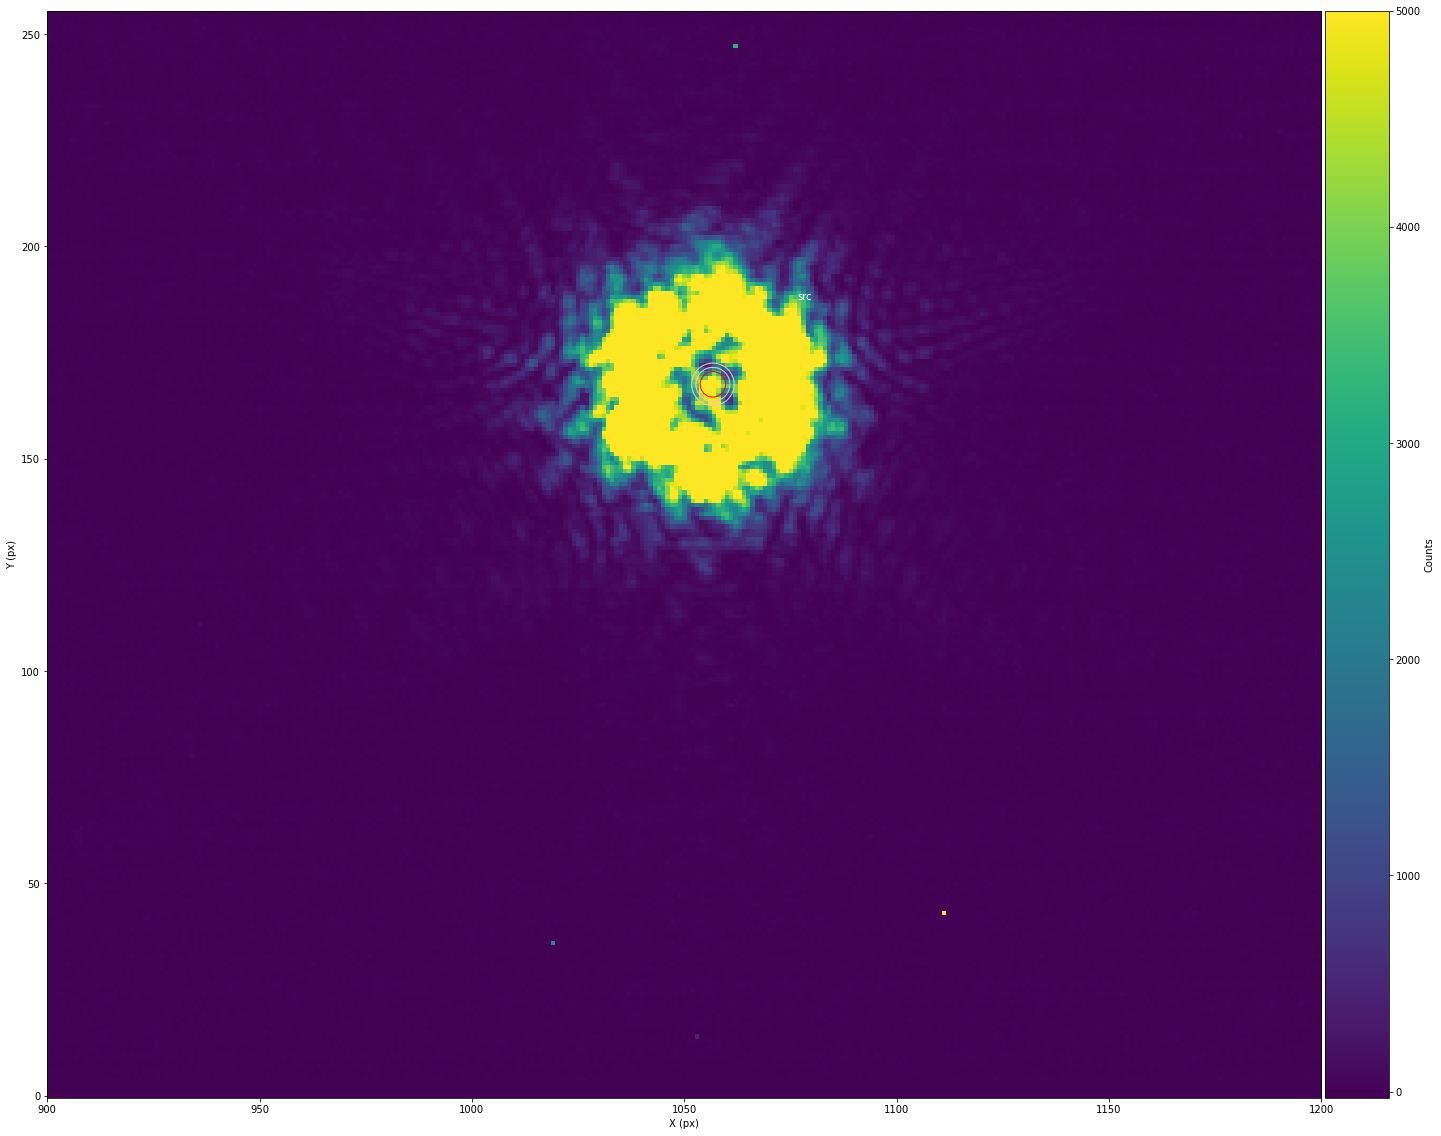

In [13]:
#Assignimg a object phot
phot = phot_pipeline.phot(paramFile='/fenrirdata1/kg_data/pipeline_output/WASP80b_WLP4/WASP80b_WLP4_NRCA3_phot_pipeline.yaml') #create a photometric object
phot.showStarChoices(showAps=True,showPlot=True,apColor='red',backColor='pink', figSize=(30,20), xLim=[900,1200],vmax=5000) #Plot the source and background subtraction area

In [14]:
phot.get_allimg_cen(recenter=True,useMultiprocessing=True) #recenter the centroids each time. 
phot.do_phot(useMultiprocessing=True) #extract the photometric data

  0%|                                                  | 0/1227 [00:00<?, ?it/s]2022-02-22 21:24:36,522 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:24:36,529 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:24:36,532 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:24:36,538 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/

2022-02-22 21:24:36,962 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:24:37,083 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

  1%|▎                                        | 11/1227 [00:00<01:23, 14.64it/s]2022-02-22 21:24:37,096 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:24:37,102 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/

2022-02-22 21:24:37,515 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:24:37,527 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:24:37,649 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:24:37,673 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may 

2022-02-22 21:24:38,076 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:24:38,086 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:24:38,099 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:24:38,201 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may 

2022-02-22 21:24:38,629 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:24:38,629 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:24:38,630 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:24:38,648 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may 

2022-02-22 21:24:39,244 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:24:39,246 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:24:39,270 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:24:39,320 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may 

2022-02-22 21:24:39,783 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:24:39,804 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:24:39,804 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

  7%|██▉                                      | 88/1227 [00:03<00:37, 30.65it/s]2022-02-22 21:24:39,812 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/

2022-02-22 21:24:40,341 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:24:40,346 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:24:40,359 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:24:40,375 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may 

  9%|███▋                                    | 114/1227 [00:04<00:42, 25.90it/s]2022-02-22 21:24:40,884 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:24:40,904 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:24:40,909 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:24:40,914 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/

2022-02-22 21:24:41,436 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:24:41,453 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:24:41,461 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:24:41,469 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may 

2022-02-22 21:24:41,965 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:24:41,986 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:24:41,986 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:24:42,002 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may 

2022-02-22 21:24:42,510 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:24:42,520 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:24:42,543 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:24:42,545 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may 

2022-02-22 21:24:42,989 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

 14%|█████▌                                  | 171/1227 [00:06<00:40, 25.94it/s]2022-02-22 21:24:43,060 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:24:43,077 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:24:43,094 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/

2022-02-22 21:24:43,534 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:24:43,534 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:24:43,620 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:24:43,642 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may 

2022-02-22 21:24:44,060 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:24:44,065 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

 16%|██████▌                                 | 201/1227 [00:07<00:37, 27.67it/s]2022-02-22 21:24:44,100 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:24:44,167 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/

2022-02-22 21:24:44,616 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:24:44,619 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:24:44,624 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:24:44,647 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may 

2022-02-22 21:24:45,227 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:24:45,245 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:24:45,252 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:24:45,293 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may 

2022-02-22 21:24:45,776 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:24:45,780 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:24:45,806 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:24:45,814 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may 

2022-02-22 21:24:46,319 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:24:46,343 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:24:46,357 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:24:46,362 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may 

2022-02-22 21:24:46,839 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

 22%|████████▉                               | 275/1227 [00:10<00:38, 24.75it/s]2022-02-22 21:24:46,869 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:24:46,896 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:24:46,910 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/

2022-02-22 21:24:47,398 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:24:47,405 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:24:47,431 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:24:47,458 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may 

2022-02-22 21:24:47,916 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

 25%|█████████▉                              | 303/1227 [00:11<00:38, 24.01it/s]2022-02-22 21:24:47,951 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:24:47,954 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:24:47,981 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/

2022-02-22 21:24:48,462 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

 26%|██████████▍                             | 320/1227 [00:12<00:31, 29.15it/s]2022-02-22 21:24:48,469 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:24:48,509 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:24:48,514 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/

2022-02-22 21:24:49,044 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:24:49,056 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:24:49,105 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

 27%|██████████▉                             | 334/1227 [00:12<00:38, 23.05it/s]2022-02-22 21:24:49,118 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/

2022-02-22 21:24:49,557 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:24:49,606 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:24:49,638 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:24:49,648 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may 

 30%|███████████▊                            | 363/1227 [00:13<00:31, 27.01it/s]2022-02-22 21:24:50,120 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:24:50,126 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:24:50,173 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:24:50,187 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/

2022-02-22 21:24:50,783 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

 31%|████████████▍                           | 380/1227 [00:14<00:32, 26.37it/s]2022-02-22 21:24:50,800 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:24:50,800 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:24:50,838 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/

2022-02-22 21:24:51,372 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:24:51,385 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

 32%|████████████▉                           | 395/1227 [00:15<00:32, 25.94it/s]2022-02-22 21:24:51,392 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:24:51,412 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/

 33%|█████████████▎                          | 408/1227 [00:15<00:31, 26.20it/s]2022-02-22 21:24:51,895 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:24:51,899 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:24:51,917 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:24:51,942 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/

2022-02-22 21:24:52,436 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:24:52,443 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:24:52,450 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:24:52,458 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may 

2022-02-22 21:24:52,978 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:24:52,978 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:24:52,996 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

 36%|██████████████▎                         | 438/1227 [00:16<00:30, 25.63it/s]2022-02-22 21:24:53,002 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/

2022-02-22 21:24:53,491 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

 37%|██████████████▋                         | 452/1227 [00:17<00:28, 27.45it/s]2022-02-22 21:24:53,518 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:24:53,529 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:24:53,555 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/

2022-02-22 21:24:53,987 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:24:54,015 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:24:54,047 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:24:54,063 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may 

2022-02-22 21:24:54,525 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:24:54,531 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:24:54,572 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:24:54,590 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may 

 40%|████████████████▏                       | 495/1227 [00:18<00:26, 27.23it/s]2022-02-22 21:24:55,078 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:24:55,084 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:24:55,128 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:24:55,146 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/

2022-02-22 21:24:55,633 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:24:55,639 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:24:55,648 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

 42%|████████████████▋                       | 511/1227 [00:19<00:25, 28.43it/s]2022-02-22 21:24:55,687 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/

2022-02-22 21:24:56,162 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:24:56,198 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:24:56,202 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

 43%|█████████████████                       | 525/1227 [00:20<00:26, 26.51it/s]2022-02-22 21:24:56,213 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/

 44%|█████████████████▌                      | 538/1227 [00:20<00:26, 25.69it/s]2022-02-22 21:24:56,706 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:24:56,717 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:24:56,753 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:24:56,754 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/

2022-02-22 21:24:57,222 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:24:57,255 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:24:57,262 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:24:57,273 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may 

2022-02-22 21:24:57,763 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:24:57,783 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:24:57,797 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

 46%|██████████████████▌                     | 568/1227 [00:21<00:25, 26.06it/s]2022-02-22 21:24:57,809 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/

 47%|██████████████████▉                     | 581/1227 [00:22<00:25, 25.77it/s]2022-02-22 21:24:58,291 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:24:58,326 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:24:58,327 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:24:58,335 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/

2022-02-22 21:24:58,839 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:24:58,844 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:24:58,873 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:24:58,878 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may 

2022-02-22 21:24:59,413 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:24:59,430 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:24:59,437 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:24:59,443 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may 

2022-02-22 21:24:59,954 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:24:59,956 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

 51%|████████████████████▎                   | 625/1227 [00:23<00:25, 23.62it/s]2022-02-22 21:24:59,982 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:24:59,986 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/

2022-02-22 21:25:00,460 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

 52%|████████████████████▉                   | 641/1227 [00:24<00:19, 29.30it/s]2022-02-22 21:25:00,496 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:25:00,512 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:25:00,538 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/

2022-02-22 21:25:00,945 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:25:01,014 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:25:01,043 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:25:01,073 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may 

2022-02-22 21:25:01,553 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:25:01,562 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:25:01,601 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

 55%|█████████████████████▉                  | 672/1227 [00:25<00:18, 30.34it/s]2022-02-22 21:25:01,636 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/

2022-02-22 21:25:02,118 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:25:02,125 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:25:02,171 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:25:02,187 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may 

2022-02-22 21:25:02,628 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:25:02,661 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

 57%|██████████████████████▊                 | 700/1227 [00:26<00:18, 28.63it/s]2022-02-22 21:25:02,672 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:25:02,718 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/

2022-02-22 21:25:03,200 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:25:03,251 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:25:03,308 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:25:03,315 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may 

2022-02-22 21:25:03,801 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:25:03,808 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:25:03,873 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

 60%|███████████████████████▊                | 731/1227 [00:27<00:18, 26.23it/s]2022-02-22 21:25:03,901 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/

 60%|████████████████████████▏               | 741/1227 [00:28<00:21, 22.61it/s]2022-02-22 21:25:04,352 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:25:04,357 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:25:04,359 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:25:04,454 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/

2022-02-22 21:25:04,880 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:25:04,893 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:25:04,909 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:25:04,920 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may 

2022-02-22 21:25:05,429 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:25:05,449 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:25:05,451 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:25:05,457 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may 

2022-02-22 21:25:05,978 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:25:05,978 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:25:05,993 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:25:06,010 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may 

2022-02-22 21:25:06,530 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:25:06,532 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:25:06,533 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:25:06,560 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may 

2022-02-22 21:25:07,093 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:25:07,095 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:25:07,118 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:25:07,124 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may 

2022-02-22 21:25:07,633 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:25:07,634 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:25:07,638 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

 68%|███████████████████████████             | 832/1227 [00:31<00:13, 28.75it/s]2022-02-22 21:25:07,691 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/

2022-02-22 21:25:08,258 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:25:08,264 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

 69%|███████████████████████████▌            | 846/1227 [00:32<00:15, 24.35it/s]2022-02-22 21:25:08,297 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:25:08,326 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/

2022-02-22 21:25:08,839 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:25:08,867 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:25:08,881 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:25:08,895 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may 

2022-02-22 21:25:09,358 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:25:09,392 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

 71%|████████████████████████████▌           | 876/1227 [00:33<00:14, 24.42it/s]2022-02-22 21:25:09,419 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:25:09,434 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/

2022-02-22 21:25:09,907 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:25:09,917 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:25:09,955 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:25:09,979 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may 

2022-02-22 21:25:10,457 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:25:10,488 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:25:10,505 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

 74%|█████████████████████████████▌          | 906/1227 [00:34<00:13, 24.63it/s]2022-02-22 21:25:10,531 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/

2022-02-22 21:25:11,044 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:25:11,053 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:25:11,068 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:25:11,098 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may 

2022-02-22 21:25:11,553 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:25:11,605 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

 76%|██████████████████████████████▍         | 935/1227 [00:35<00:12, 23.96it/s]2022-02-22 21:25:11,611 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:25:11,614 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/

2022-02-22 21:25:12,185 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

 78%|███████████████████████████████         | 953/1227 [00:35<00:09, 30.23it/s]2022-02-22 21:25:12,205 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:25:12,210 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:25:12,243 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/

2022-02-22 21:25:12,709 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:25:12,722 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:25:12,754 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:25:12,758 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may 

2022-02-22 21:25:13,248 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

 80%|████████████████████████████████        | 982/1227 [00:37<00:07, 30.69it/s]2022-02-22 21:25:13,270 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:25:13,310 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:25:13,327 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/

2022-02-22 21:25:13,784 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:25:13,794 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:25:13,810 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:25:13,872 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may 

2022-02-22 21:25:14,320 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:25:14,334 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:25:14,343 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:25:14,382 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may 

2022-02-22 21:25:14,880 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:25:14,894 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:25:14,898 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:25:14,899 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may 

2022-02-22 21:25:15,402 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:25:15,421 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:25:15,440 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:25:15,442 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may 

2022-02-22 21:25:15,953 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:25:15,974 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:25:15,981 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:25:15,984 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may 

2022-02-22 21:25:16,500 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:25:16,507 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:25:16,527 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:25:16,530 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may 

2022-02-22 21:25:17,010 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:25:17,071 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:25:17,074 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:25:17,092 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may 

2022-02-22 21:25:17,554 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

 89%|██████████████████████████████████▊    | 1095/1227 [00:41<00:05, 24.73it/s]2022-02-22 21:25:17,567 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:25:17,628 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:25:17,641 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/

2022-02-22 21:25:18,112 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:25:18,113 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:25:18,134 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:25:18,195 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may 

2022-02-22 21:25:18,629 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:25:18,660 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

 92%|███████████████████████████████████▋   | 1124/1227 [00:42<00:04, 23.63it/s]2022-02-22 21:25:18,666 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:25:18,678 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/

2022-02-22 21:25:19,162 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:25:19,175 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:25:19,228 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:25:19,234 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may 

2022-02-22 21:25:19,722 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

 94%|████████████████████████████████████▋  | 1153/1227 [00:43<00:02, 25.99it/s]2022-02-22 21:25:19,727 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:25:19,728 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:25:19,765 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/

2022-02-22 21:25:20,275 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:25:20,277 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:25:20,291 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:25:20,323 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may 

2022-02-22 21:25:20,840 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:25:20,842 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:25:20,843 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:25:20,844 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may 

2022-02-22 21:25:21,387 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:25:21,396 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:25:21,406 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:25:21,406 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may 

 99%|██████████████████████████████████████▌| 1213/1227 [00:45<00:00, 26.90it/s]2022-02-22 21:25:21,953 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:25:21,964 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:25:21,965 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:25:21,973 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/

  0%|                                          | 1/1227 [00:00<03:42,  5.51it/s]2022-02-22 21:25:22,871 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/utils.py:94: UserWarning: Less than 0points accepted, returning flat line
  warnings.warn(warntext)

2022-02-22 21:25:22,879 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/utils.py:94: UserWarning: Less than 0points accepted, returning flat line
  warnings.warn(warntext)

2022-02-22 21:25:22,889 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/utils.py:94: UserWarning: Less than 0points accepted, returning flat line
  warnings.warn(warntext)

2022-02-22 21:25:22,890 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/utils.py:94: UserWarning: Less than 0points accepted, returning flat line
  warnings.warn(warntex

2022-02-22 21:25:23,305 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/utils.py:94: UserWarning: Less than 0points accepted, returning flat line
  warnings.warn(warntext)

2022-02-22 21:25:23,309 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/utils.py:94: UserWarning: Less than 0points accepted, returning flat line
  warnings.warn(warntext)

2022-02-22 21:25:23,325 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/utils.py:94: UserWarning: Less than 0points accepted, returning flat line
  warnings.warn(warntext)

  3%|█▍                                       | 42/1227 [00:00<00:14, 80.63it/s]2022-02-22 21:25:23,369 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/utils.py:94: UserWarning: Less than 0points accepted, returning flat line
  warnings.warn(warntex

2022-02-22 21:25:23,704 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/utils.py:94: UserWarning: Less than 0points accepted, returning flat line
  warnings.warn(warntext)

2022-02-22 21:25:23,722 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/utils.py:94: UserWarning: Less than 0points accepted, returning flat line
  warnings.warn(warntext)

2022-02-22 21:25:23,739 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/utils.py:94: UserWarning: Less than 0points accepted, returning flat line
  warnings.warn(warntext)

2022-02-22 21:25:23,753 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/utils.py:94: UserWarning: Less than 0points accepted, returning flat line
  warnings.warn(warntext)

  6%|██▋                                      | 79/1227 [00:01<00:12, 88.92i

2022-02-22 21:25:24,075 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/utils.py:94: UserWarning: Less than 0points accepted, returning flat line
  warnings.warn(warntext)

2022-02-22 21:25:24,075 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/utils.py:94: UserWarning: Less than 0points accepted, returning flat line
  warnings.warn(warntext)

  9%|███▌                                    | 110/1227 [00:01<00:12, 92.70it/s]2022-02-22 21:25:24,087 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/utils.py:94: UserWarning: Less than 0points accepted, returning flat line
  warnings.warn(warntext)

2022-02-22 21:25:24,105 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/utils.py:94: UserWarning: Less than 0points accepted, returning flat line
  warnings.warn(warntex

2022-02-22 21:25:24,448 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/utils.py:94: UserWarning: Less than 0points accepted, returning flat line
  warnings.warn(warntext)

2022-02-22 21:25:24,453 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/utils.py:94: UserWarning: Less than 0points accepted, returning flat line
  warnings.warn(warntext)

2022-02-22 21:25:24,461 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/utils.py:94: UserWarning: Less than 0points accepted, returning flat line
  warnings.warn(warntext)

2022-02-22 21:25:24,479 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/utils.py:94: UserWarning: Less than 0points accepted, returning flat line
  warnings.warn(warntext)

2022-02-22 21:25:24,492 - stpipe - WARNING - /home/kglidic/miniconda3/envs/J

 15%|█████▊                                  | 180/1227 [00:02<00:11, 94.75it/s]2022-02-22 21:25:24,819 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/utils.py:94: UserWarning: Less than 0points accepted, returning flat line
  warnings.warn(warntext)

2022-02-22 21:25:24,843 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/utils.py:94: UserWarning: Less than 0points accepted, returning flat line
  warnings.warn(warntext)

2022-02-22 21:25:24,845 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/utils.py:94: UserWarning: Less than 0points accepted, returning flat line
  warnings.warn(warntext)

2022-02-22 21:25:24,846 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/utils.py:94: UserWarning: Less than 0points accepted, returning flat line
  warnings.warn(warntex

2022-02-22 21:25:25,178 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/utils.py:94: UserWarning: Less than 0points accepted, returning flat line
  warnings.warn(warntext)

2022-02-22 21:25:25,186 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/utils.py:94: UserWarning: Less than 0points accepted, returning flat line
  warnings.warn(warntext)

2022-02-22 21:25:25,196 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/utils.py:94: UserWarning: Less than 0points accepted, returning flat line
  warnings.warn(warntext)

2022-02-22 21:25:25,211 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/utils.py:94: UserWarning: Less than 0points accepted, returning flat line
  warnings.warn(warntext)

2022-02-22 21:25:25,214 - stpipe - WARNING - /home/kglidic/miniconda3/envs/J

2022-02-22 21:25:25,520 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/utils.py:94: UserWarning: Less than 0points accepted, returning flat line
  warnings.warn(warntext)

 20%|████████▏                               | 250/1227 [00:02<00:10, 96.27it/s]2022-02-22 21:25:25,551 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/utils.py:94: UserWarning: Less than 0points accepted, returning flat line
  warnings.warn(warntext)

2022-02-22 21:25:25,552 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/utils.py:94: UserWarning: Less than 0points accepted, returning flat line
  warnings.warn(warntext)

2022-02-22 21:25:25,569 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/utils.py:94: UserWarning: Less than 0points accepted, returning flat line
  warnings.warn(warntex

2022-02-22 21:25:25,908 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/utils.py:94: UserWarning: Less than 0points accepted, returning flat line
  warnings.warn(warntext)

2022-02-22 21:25:25,908 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/utils.py:94: UserWarning: Less than 0points accepted, returning flat line
  warnings.warn(warntext)

2022-02-22 21:25:25,911 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/utils.py:94: UserWarning: Less than 0points accepted, returning flat line
  warnings.warn(warntext)

2022-02-22 21:25:25,950 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/utils.py:94: UserWarning: Less than 0points accepted, returning flat line
  warnings.warn(warntext)

2022-02-22 21:25:25,954 - stpipe - WARNING - /home/kglidic/miniconda3/envs/J

2022-02-22 21:25:26,292 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/utils.py:94: UserWarning: Less than 0points accepted, returning flat line
  warnings.warn(warntext)

2022-02-22 21:25:26,298 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/utils.py:94: UserWarning: Less than 0points accepted, returning flat line
  warnings.warn(warntext)

 26%|██████████▍                             | 322/1227 [00:03<00:10, 89.62it/s]2022-02-22 21:25:26,323 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/utils.py:94: UserWarning: Less than 0points accepted, returning flat line
  warnings.warn(warntext)

2022-02-22 21:25:26,331 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/utils.py:94: UserWarning: Less than 0points accepted, returning flat line
  warnings.warn(warntex

2022-02-22 21:25:26,649 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/utils.py:94: UserWarning: Less than 0points accepted, returning flat line
  warnings.warn(warntext)

2022-02-22 21:25:26,655 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/utils.py:94: UserWarning: Less than 0points accepted, returning flat line
  warnings.warn(warntext)

2022-02-22 21:25:26,667 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/utils.py:94: UserWarning: Less than 0points accepted, returning flat line
  warnings.warn(warntext)

2022-02-22 21:25:26,673 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/utils.py:94: UserWarning: Less than 0points accepted, returning flat line
  warnings.warn(warntext)

2022-02-22 21:25:26,715 - stpipe - WARNING - /home/kglidic/miniconda3/envs/J

2022-02-22 21:25:27,034 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/utils.py:94: UserWarning: Less than 0points accepted, returning flat line
  warnings.warn(warntext)

2022-02-22 21:25:27,039 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/utils.py:94: UserWarning: Less than 0points accepted, returning flat line
  warnings.warn(warntext)

 32%|████████████▊                           | 392/1227 [00:04<00:08, 93.67it/s]2022-02-22 21:25:27,061 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/utils.py:94: UserWarning: Less than 0points accepted, returning flat line
  warnings.warn(warntext)

2022-02-22 21:25:27,072 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/utils.py:94: UserWarning: Less than 0points accepted, returning flat line
  warnings.warn(warntex

2022-02-22 21:25:27,439 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/utils.py:94: UserWarning: Less than 0points accepted, returning flat line
  warnings.warn(warntext)

2022-02-22 21:25:27,454 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/utils.py:94: UserWarning: Less than 0points accepted, returning flat line
  warnings.warn(warntext)

2022-02-22 21:25:27,464 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/utils.py:94: UserWarning: Less than 0points accepted, returning flat line
  warnings.warn(warntext)

2022-02-22 21:25:27,473 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/utils.py:94: UserWarning: Less than 0points accepted, returning flat line
  warnings.warn(warntext)

2022-02-22 21:25:27,475 - stpipe - WARNING - /home/kglidic/miniconda3/envs/J

2022-02-22 21:25:27,869 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/utils.py:94: UserWarning: Less than 0points accepted, returning flat line
  warnings.warn(warntext)

2022-02-22 21:25:27,872 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/utils.py:94: UserWarning: Less than 0points accepted, returning flat line
  warnings.warn(warntext)

2022-02-22 21:25:27,877 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/utils.py:94: UserWarning: Less than 0points accepted, returning flat line
  warnings.warn(warntext)

2022-02-22 21:25:27,879 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/utils.py:94: UserWarning: Less than 0points accepted, returning flat line
  warnings.warn(warntext)

2022-02-22 21:25:27,880 - stpipe - WARNING - /home/kglidic/miniconda3/envs/J

2022-02-22 21:25:28,235 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/utils.py:94: UserWarning: Less than 0points accepted, returning flat line
  warnings.warn(warntext)

 40%|████████████████                        | 492/1227 [00:05<00:08, 84.56it/s]2022-02-22 21:25:28,244 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/utils.py:94: UserWarning: Less than 0points accepted, returning flat line
  warnings.warn(warntext)

2022-02-22 21:25:28,253 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/utils.py:94: UserWarning: Less than 0points accepted, returning flat line
  warnings.warn(warntext)

2022-02-22 21:25:28,268 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/utils.py:94: UserWarning: Less than 0points accepted, returning flat line
  warnings.warn(warntex

2022-02-22 21:25:28,653 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/utils.py:94: UserWarning: Less than 0points accepted, returning flat line
  warnings.warn(warntext)

2022-02-22 21:25:28,654 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/utils.py:94: UserWarning: Less than 0points accepted, returning flat line
  warnings.warn(warntext)

2022-02-22 21:25:28,658 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/utils.py:94: UserWarning: Less than 0points accepted, returning flat line
  warnings.warn(warntext)

2022-02-22 21:25:28,660 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/utils.py:94: UserWarning: Less than 0points accepted, returning flat line
  warnings.warn(warntext)

 43%|█████████████████▎                      | 532/1227 [00:05<00:07, 91.31i

2022-02-22 21:25:29,002 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/utils.py:94: UserWarning: Less than 0points accepted, returning flat line
  warnings.warn(warntext)

2022-02-22 21:25:29,003 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/utils.py:94: UserWarning: Less than 0points accepted, returning flat line
  warnings.warn(warntext)

 46%|██████████████████▎                     | 563/1227 [00:06<00:07, 89.46it/s]2022-02-22 21:25:29,018 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/utils.py:94: UserWarning: Less than 0points accepted, returning flat line
  warnings.warn(warntext)

2022-02-22 21:25:29,022 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/utils.py:94: UserWarning: Less than 0points accepted, returning flat line
  warnings.warn(warntex

2022-02-22 21:25:29,374 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/utils.py:94: UserWarning: Less than 0points accepted, returning flat line
  warnings.warn(warntext)

2022-02-22 21:25:29,378 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/utils.py:94: UserWarning: Less than 0points accepted, returning flat line
  warnings.warn(warntext)

2022-02-22 21:25:29,384 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/utils.py:94: UserWarning: Less than 0points accepted, returning flat line
  warnings.warn(warntext)

2022-02-22 21:25:29,408 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/utils.py:94: UserWarning: Less than 0points accepted, returning flat line
  warnings.warn(warntext)

2022-02-22 21:25:29,411 - stpipe - WARNING - /home/kglidic/miniconda3/envs/J

2022-02-22 21:25:29,750 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/utils.py:94: UserWarning: Less than 0points accepted, returning flat line
  warnings.warn(warntext)

2022-02-22 21:25:29,758 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/utils.py:94: UserWarning: Less than 0points accepted, returning flat line
  warnings.warn(warntext)

 52%|████████████████████▊                   | 637/1227 [00:07<00:06, 95.69it/s]2022-02-22 21:25:29,785 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/utils.py:94: UserWarning: Less than 0points accepted, returning flat line
  warnings.warn(warntext)

2022-02-22 21:25:29,793 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/utils.py:94: UserWarning: Less than 0points accepted, returning flat line
  warnings.warn(warntex

2022-02-22 21:25:30,119 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/utils.py:94: UserWarning: Less than 0points accepted, returning flat line
  warnings.warn(warntext)

2022-02-22 21:25:30,122 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/utils.py:94: UserWarning: Less than 0points accepted, returning flat line
  warnings.warn(warntext)

2022-02-22 21:25:30,134 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/utils.py:94: UserWarning: Less than 0points accepted, returning flat line
  warnings.warn(warntext)

2022-02-22 21:25:30,139 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/utils.py:94: UserWarning: Less than 0points accepted, returning flat line
  warnings.warn(warntext)

2022-02-22 21:25:30,142 - stpipe - WARNING - /home/kglidic/miniconda3/envs/J

2022-02-22 21:25:30,476 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/utils.py:94: UserWarning: Less than 0points accepted, returning flat line
  warnings.warn(warntext)

2022-02-22 21:25:30,485 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/utils.py:94: UserWarning: Less than 0points accepted, returning flat line
  warnings.warn(warntext)

 58%|███████████████████████                 | 707/1227 [00:07<00:05, 97.16it/s]2022-02-22 21:25:30,500 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/utils.py:94: UserWarning: Less than 0points accepted, returning flat line
  warnings.warn(warntext)

2022-02-22 21:25:30,509 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/utils.py:94: UserWarning: Less than 0points accepted, returning flat line
  warnings.warn(warntex

2022-02-22 21:25:30,871 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/utils.py:94: UserWarning: Less than 0points accepted, returning flat line
  warnings.warn(warntext)

2022-02-22 21:25:30,880 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/utils.py:94: UserWarning: Less than 0points accepted, returning flat line
  warnings.warn(warntext)

2022-02-22 21:25:30,882 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/utils.py:94: UserWarning: Less than 0points accepted, returning flat line
  warnings.warn(warntext)

2022-02-22 21:25:30,885 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/utils.py:94: UserWarning: Less than 0points accepted, returning flat line
  warnings.warn(warntext)

2022-02-22 21:25:30,887 - stpipe - WARNING - /home/kglidic/miniconda3/envs/J

2022-02-22 21:25:31,258 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/utils.py:94: UserWarning: Less than 0points accepted, returning flat line
  warnings.warn(warntext)

2022-02-22 21:25:31,265 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/utils.py:94: UserWarning: Less than 0points accepted, returning flat line
  warnings.warn(warntext)

2022-02-22 21:25:31,278 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/utils.py:94: UserWarning: Less than 0points accepted, returning flat line
  warnings.warn(warntext)

 63%|█████████████████████████▎              | 775/1227 [00:08<00:05, 80.80it/s]2022-02-22 21:25:31,284 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/utils.py:94: UserWarning: Less than 0points accepted, returning flat line
  warnings.warn(warntex

2022-02-22 21:25:31,609 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/utils.py:94: UserWarning: Less than 0points accepted, returning flat line
  warnings.warn(warntext)

 66%|██████████████████████████▍             | 810/1227 [00:08<00:04, 97.31it/s]2022-02-22 21:25:31,623 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/utils.py:94: UserWarning: Less than 0points accepted, returning flat line
  warnings.warn(warntext)

2022-02-22 21:25:31,637 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/utils.py:94: UserWarning: Less than 0points accepted, returning flat line
  warnings.warn(warntext)

2022-02-22 21:25:31,639 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/utils.py:94: UserWarning: Less than 0points accepted, returning flat line
  warnings.warn(warntex

 69%|███████████████████████████▍            | 842/1227 [00:09<00:04, 95.55it/s]2022-02-22 21:25:31,993 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/utils.py:94: UserWarning: Less than 0points accepted, returning flat line
  warnings.warn(warntext)

2022-02-22 21:25:32,019 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/utils.py:94: UserWarning: Less than 0points accepted, returning flat line
  warnings.warn(warntext)

2022-02-22 21:25:32,033 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/utils.py:94: UserWarning: Less than 0points accepted, returning flat line
  warnings.warn(warntext)

2022-02-22 21:25:32,040 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/utils.py:94: UserWarning: Less than 0points accepted, returning flat line
  warnings.warn(warntex

2022-02-22 21:25:32,396 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/utils.py:94: UserWarning: Less than 0points accepted, returning flat line
  warnings.warn(warntext)

2022-02-22 21:25:32,402 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/utils.py:94: UserWarning: Less than 0points accepted, returning flat line
  warnings.warn(warntext)

2022-02-22 21:25:32,411 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/utils.py:94: UserWarning: Less than 0points accepted, returning flat line
  warnings.warn(warntext)

2022-02-22 21:25:32,412 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/utils.py:94: UserWarning: Less than 0points accepted, returning flat line
  warnings.warn(warntext)

2022-02-22 21:25:32,413 - stpipe - WARNING - /home/kglidic/miniconda3/envs/J

 74%|█████████████████████████████▊          | 913/1227 [00:10<00:03, 94.23it/s]2022-02-22 21:25:32,749 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/utils.py:94: UserWarning: Less than 0points accepted, returning flat line
  warnings.warn(warntext)

2022-02-22 21:25:32,751 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/utils.py:94: UserWarning: Less than 0points accepted, returning flat line
  warnings.warn(warntext)

2022-02-22 21:25:32,784 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/utils.py:94: UserWarning: Less than 0points accepted, returning flat line
  warnings.warn(warntext)

2022-02-22 21:25:32,786 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/utils.py:94: UserWarning: Less than 0points accepted, returning flat line
  warnings.warn(warntex

2022-02-22 21:25:33,104 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/utils.py:94: UserWarning: Less than 0points accepted, returning flat line
  warnings.warn(warntext)

2022-02-22 21:25:33,116 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/utils.py:94: UserWarning: Less than 0points accepted, returning flat line
  warnings.warn(warntext)

2022-02-22 21:25:33,139 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/utils.py:94: UserWarning: Less than 0points accepted, returning flat line
  warnings.warn(warntext)

2022-02-22 21:25:33,161 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/utils.py:94: UserWarning: Less than 0points accepted, returning flat line
  warnings.warn(warntext)

2022-02-22 21:25:33,170 - stpipe - WARNING - /home/kglidic/miniconda3/envs/J

 80%|████████████████████████████████        | 985/1227 [00:10<00:02, 96.27it/s]2022-02-22 21:25:33,498 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/utils.py:94: UserWarning: Less than 0points accepted, returning flat line
  warnings.warn(warntext)

2022-02-22 21:25:33,500 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/utils.py:94: UserWarning: Less than 0points accepted, returning flat line
  warnings.warn(warntext)

2022-02-22 21:25:33,501 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/utils.py:94: UserWarning: Less than 0points accepted, returning flat line
  warnings.warn(warntext)

2022-02-22 21:25:33,505 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/utils.py:94: UserWarning: Less than 0points accepted, returning flat line
  warnings.warn(warntex

2022-02-22 21:25:33,853 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/utils.py:94: UserWarning: Less than 0points accepted, returning flat line
  warnings.warn(warntext)

2022-02-22 21:25:33,858 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/utils.py:94: UserWarning: Less than 0points accepted, returning flat line
  warnings.warn(warntext)

2022-02-22 21:25:33,870 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/utils.py:94: UserWarning: Less than 0points accepted, returning flat line
  warnings.warn(warntext)

2022-02-22 21:25:33,881 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/utils.py:94: UserWarning: Less than 0points accepted, returning flat line
  warnings.warn(warntext)

2022-02-22 21:25:33,881 - stpipe - WARNING - /home/kglidic/miniconda3/envs/J

2022-02-22 21:25:34,212 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/utils.py:94: UserWarning: Less than 0points accepted, returning flat line
  warnings.warn(warntext)

2022-02-22 21:25:34,217 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/utils.py:94: UserWarning: Less than 0points accepted, returning flat line
  warnings.warn(warntext)

 86%|█████████████████████████████████▌     | 1057/1227 [00:11<00:01, 97.74it/s]2022-02-22 21:25:34,230 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/utils.py:94: UserWarning: Less than 0points accepted, returning flat line
  warnings.warn(warntext)

2022-02-22 21:25:34,232 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/utils.py:94: UserWarning: Less than 0points accepted, returning flat line
  warnings.warn(warntex

2022-02-22 21:25:34,590 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/utils.py:94: UserWarning: Less than 0points accepted, returning flat line
  warnings.warn(warntext)

2022-02-22 21:25:34,599 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/utils.py:94: UserWarning: Less than 0points accepted, returning flat line
  warnings.warn(warntext)

2022-02-22 21:25:34,606 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/utils.py:94: UserWarning: Less than 0points accepted, returning flat line
  warnings.warn(warntext)

2022-02-22 21:25:34,607 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/utils.py:94: UserWarning: Less than 0points accepted, returning flat line
  warnings.warn(warntext)

2022-02-22 21:25:34,632 - stpipe - WARNING - /home/kglidic/miniconda3/envs/J

2022-02-22 21:25:34,966 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/utils.py:94: UserWarning: Less than 0points accepted, returning flat line
  warnings.warn(warntext)

2022-02-22 21:25:34,968 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/utils.py:94: UserWarning: Less than 0points accepted, returning flat line
  warnings.warn(warntext)

2022-02-22 21:25:34,971 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/utils.py:94: UserWarning: Less than 0points accepted, returning flat line
  warnings.warn(warntext)

2022-02-22 21:25:34,976 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/utils.py:94: UserWarning: Less than 0points accepted, returning flat line
  warnings.warn(warntext)

2022-02-22 21:25:34,976 - stpipe - WARNING - /home/kglidic/miniconda3/envs/J

 95%|████████████████████████████████████▉  | 1161/1227 [00:12<00:00, 94.42it/s]2022-02-22 21:25:35,326 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/utils.py:94: UserWarning: Less than 0points accepted, returning flat line
  warnings.warn(warntext)

2022-02-22 21:25:35,347 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/utils.py:94: UserWarning: Less than 0points accepted, returning flat line
  warnings.warn(warntext)

2022-02-22 21:25:35,354 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/utils.py:94: UserWarning: Less than 0points accepted, returning flat line
  warnings.warn(warntext)

2022-02-22 21:25:35,363 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/utils.py:94: UserWarning: Less than 0points accepted, returning flat line
  warnings.warn(warntex

2022-02-22 21:25:35,699 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/utils.py:94: UserWarning: Less than 0points accepted, returning flat line
  warnings.warn(warntext)

2022-02-22 21:25:35,723 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/utils.py:94: UserWarning: Less than 0points accepted, returning flat line
  warnings.warn(warntext)

2022-02-22 21:25:35,724 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/utils.py:94: UserWarning: Less than 0points accepted, returning flat line
  warnings.warn(warntext)

2022-02-22 21:25:35,733 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/utils.py:94: UserWarning: Less than 0points accepted, returning flat line
  warnings.warn(warntext)

2022-02-22 21:25:35,757 - stpipe - WARNING - /home/kglidic/miniconda3/envs/J

Tshirt Calculated Net Aperture Sum MAD (ppm): 4868.474503617777
Tshirt Calculated Net Aperture Sum std (ppm): 5665.867389205953
Median Relative Errors Net Aperture Sum (ppm): 4509.583815451087


<ErrorbarContainer object of 3 artists>

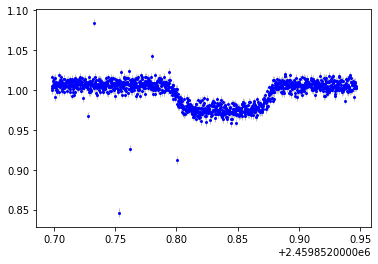

In [15]:
#Tshirt: net aperture
Flux, Flux_error = phot.get_tSeries() #The flux data and flux data errors
normalized_flux_tshirt = Flux['Flux 0']/Flux['Flux 0'][0] #normalized net aperture sum
std_tshirt = np.std(normalized_flux_tshirt[0:20]) #calculated standard deviation
relative_error_tshirt = (Flux_error['Error 0']/Flux['Flux 0'])

#MAD: 
deviation = normalized_flux_tshirt[0:seg01_len] - np.median(normalized_flux_tshirt[0:seg01_len])
mad = np.median(np.abs(deviation))*1.48

print(style.BOLD+"Tshirt Calculated Net Aperture Sum MAD (ppm):"+style.END + " " +str(mad*10**6))
print(style.BOLD+"Tshirt Calculated Net Aperture Sum std (ppm):"+style.END + " " +str(std_tshirt*10**6))
print(style.BOLD+"Median Relative Errors Net Aperture Sum (ppm):"+style.END + " " +str(np.median(relative_error_tshirt)*10**6))

plt.errorbar(Flux['Time (JD)'],normalized_flux_tshirt,yerr=relative_error_tshirt,fmt='b.',markersize=4,elinewidth=1,ecolor='silver')

# <mark>$\textbf{Plotting Results: Altered}$</mark>
Initial pipeline results with altered aperture sizes. In this particular simulation, there is an edge effect (the observation is cut off on the top and bottom). We want to see how observations that turn out this way in real life can effect the results the pipline returns. 

TSOPHOT reference files are ASDF format. An object called ‘radii’ in a TSOPHOT file defines the radii that the step needs. This object is a list of one or more dictionaries. Each such dictionary has four keys: ‘pupil’, ‘radius’, ‘radius_inner’, and ‘radius_outer’. The particular one of these dictionaries to use is selected by comparing meta.instrument.pupil with the value corresponding to ‘pupil’ in each dictionary. If an exact match is found, that dictionary will be used. If no match is found, the first dictionary with ‘pupil’: ‘ANY’ will be selected. The radii will be taken from the values of keys ‘radius’, ‘radius_inner’, and ‘radius_outer’.


NOTE: You must run these sections in order because it requires re-running stage 3 (will take a few minutes). 

## $\textbf{30-30-50 Radii}$

### $\textbf{TSO Photometry Reference File: Radii Parameters}$
The original radii parameters are: 
`radii': [{'pupil': 'WLP8',
   'radius': 50.0,
   'radius_inner': 60.0,
   'radius_outer': 70.0},
  {'pupil': 'ANY', 'radius': 3.0, 'radius_inner': 4.0, 'radius_outer': 5.0}]}`

The altered radii parameters are (to try the `pupil = CLEAR` parameters): 
   `radius: 30.0`,
   `radius_inner: 30.0`, and
   `radius_outer: 50.0`

In [23]:
original_tsophot=asdf.open("/fenrirdata1/kg_data/crds_cache/references/jwst/nircam/jwst_nircam_tsophot_0001.asdf") #the original tsophot reference file
original_tsophot.tree #print the original tsophot reference file

#adjust the radii parameters
original_tsophot.tree['radii'] = [{'pupil': 'WLP8',
   'radius': 50.0,
   'radius_inner': 60.0,
   'radius_outer': 70.0}, #For this particular data set, the outer radius limit is 62 due to edge effects on detector
  {'pupil': 'ANY', 'radius': 30.0, 'radius_inner': 30.0, 'radius_outer': 50.0}]
original_tsophot.write_to('adjusted_jwst_nircam_tsophot_0001.asdf')
adjusted_tsophot=asdf.open('adjusted_jwst_nircam_tsophot_0001.asdf') #the adjusted tsophot reference file
adjusted_tsophot.tree #print the adjusted tsophot reference file

{'asdf_library': {'author': 'Space Telescope Science Institute',
  'homepage': 'http://github.com/spacetelescope/asdf',
  'name': 'asdf',
  'version': '2.7.2'},
 'history': {'entries': [{'description': 'File created based on values of aperture radii for NIRCam that were specified as constants in tso_photometry_step.py.',
    'time': datetime.datetime(2018, 7, 13, 17, 20, 5)}],
  'extensions': [{'extension_class': 'asdf.extension.BuiltinExtension',
    'software': {'name': 'asdf', 'version': '2.7.2'}},
   {'extension_class': 'astropy.io.misc.asdf.extension.AstropyAsdfExtension',
    'software': {'name': 'astropy', 'version': '4.2.1'}},
   {'extension_class': 'astropy.io.misc.asdf.extension.AstropyExtension',
    'software': {'name': 'astropy', 'version': '4.2.1'}},
   {'extension_class': 'gwcs.extension.GWCSExtension',
    'software': {'name': 'gwcs', 'version': '0.16.1'}}]},
 'meta': {'author': 'NIRCam IDT; P. Hodge',
  'date': '2018-07-13T17:20:00',
  'description': 'aperture radii fo

In [24]:
#The file to use is the stage 3 association file defined above. 

# Instantiate the class. Do not provide a configuration file.
pipeline_stage3 = Tso3Pipeline()

pipeline_stage3.outlier_detection.skip = True
pipeline_stage3.tso_photometry.override_tsophot = 'adjusted_jwst_nircam_tsophot_0001.asdf' #use the modified tso_phot ref file

# Specify that you want results saved to a file
pipeline_stage3.save_results = True
pipeline_stage3.output_dir = '/fenrirdata1/kg_data/pipeline_output/WASP80b_WLP4/303050_radii'

# Execute the pipeline using the run method
result_stage3 = pipeline_stage3.run(level3_asn)

2021-11-08 22:54:29,026 - stpipe.Tso3Pipeline - INFO - Tso3Pipeline instance created.
2021-11-08 22:54:29,034 - stpipe.Tso3Pipeline.outlier_detection - INFO - OutlierDetectionStep instance created.
2021-11-08 22:54:29,039 - stpipe.Tso3Pipeline.tso_photometry - INFO - TSOPhotometryStep instance created.
2021-11-08 22:54:29,045 - stpipe.Tso3Pipeline.extract_1d - INFO - Extract1dStep instance created.
2021-11-08 22:54:29,050 - stpipe.Tso3Pipeline.white_light - INFO - WhiteLightStep instance created.
2021-11-08 22:54:29,638 - stpipe.Tso3Pipeline - INFO - Step Tso3Pipeline running with args ('/fenrirdata1/kg_data/pipeline_output/WASP80b_WLP4/nrca3_level3_asn.json',).
2021-11-08 22:54:29,649 - stpipe.Tso3Pipeline - INFO - Step Tso3Pipeline parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': '/fenrirdata1/kg_data/pipeline_output/WASP80b_WLP4/303050_radii', 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip

2021-11-08 22:56:19,166 - stpipe.Tso3Pipeline.outlier_detection - INFO - Step outlier_detection parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': 'outlier_detection', 'search_output_file': False, 'input_dir': '/fenrirdata1/kg_data/pipeline_output/WASP80b_WLP4', 'weight_type': 'ivm', 'pixfrac': 1.0, 'kernel': 'square', 'fillval': 'INDEF', 'nlow': 0, 'nhigh': 0, 'maskpt': 0.7, 'grow': 1, 'snr': '5.0 4.0', 'scale': '1.2 0.7', 'backg': 0.0, 'save_intermediate_results': False, 'resample_data': True, 'good_bits': '~DO_NOT_USE', 'scale_detection': False, 'allowed_memory': None}
2021-11-08 22:56:19,168 - stpipe.Tso3Pipeline.outlier_detection - INFO - Step skipped.
2021-11-08 22:56:19,267 - stpipe.Tso3Pipeline.outlier_detection - INFO - Step outlier_detection done
2021-11-08 22:56:32,601 - stpipe.Tso3Pipeline - INFO - Performing ou

In [19]:
#Import the stage 3 result file with all the data
with open('/fenrirdata1/kg_data/pipeline_output/WASP80b_WLP4/303050_radii/WASP80b_WLP4_nrca3_level3_asn_phot.ecsv', 'r') as file:
    reader = csv.reader(file)
    for row in reader:
        print(row)

['# %ECSV 0.9']
['# ---']
['# datatype:']
['# - {name: MJD', ' datatype: float64}']
['# - {name: aperture_sum', ' unit: Jy', ' datatype: float64}']
['# - {name: aperture_sum_err', ' unit: Jy', ' datatype: float64}']
['# - {name: annulus_sum', ' unit: Jy', ' datatype: float64}']
['# - {name: annulus_sum_err', ' unit: Jy', ' datatype: float64}']
['# - {name: annulus_mean', ' unit: Jy', ' datatype: float64}']
['# - {name: annulus_mean_err', ' unit: Jy', ' datatype: float64}']
['# - {name: aperture_bkg', ' unit: Jy', ' datatype: float64}']
['# - {name: aperture_bkg_err', ' unit: Jy', ' datatype: float64}']
['# - {name: net_aperture_sum', ' unit: Jy', ' datatype: float64}']
['# - {name: net_aperture_sum_err', ' unit: Jy', ' datatype: float64}']
['# meta: !!omap']
['# - {instrument: NIRCAM}']
['# - {detector: NRCA3}']
['# - {channel: SHORT}']
['# - {subarray: SUBGRISM256}']
['# - {filter: WLP4}']
['# - {pupil: CLEAR}']
['# - {target_name: UNKNOWN}']
['# - {xcenter: 1055.75}']
['# - {ycenter:

['59852.41014503519 0.2531556823365042 6.718903557360298e-05 0.03360739421668005 2.3015017331376357e-05 6.685978642528257e-06 4.578692217042736e-09 0.018904159246882525 1.29459472488992e-05 0.2342515230896217 6.8424878892711e-05']
['59852.41034766215 0.2533734297876447 6.719930653235828e-05 0.03400822759805666 2.3019690560278513e-05 6.765721910031165e-06 4.5796219263927084e-09 0.01912962802390687 1.2948575940156663e-05 0.23424380176373785 6.84354616942697e-05']
['59852.41055028912 0.25316034176789504 6.718751029567063e-05 0.033746459693060275 2.301636774375142e-05 6.713644840002435e-06 4.578960873048616e-09 0.018982383577346405 1.2946706855860173e-05 0.23417795819054862 6.842352488831911e-05']
['59852.41075291609 0.25338052165954084 6.720534467311503e-05 0.03373746232234917 2.301565490937266e-05 6.711854869973057e-06 4.578819059154884e-09 0.018977322556321407 1.294630588652212e-05 0.23440319910321944 6.844096133705011e-05']
['59852.410955543055 0.2532523230714722 6.719583412307509e-05 

Pipeline Calculated Net Aperture Sum MAD (ppm): 531.6748660166982
Pipeline Calculated Net Aperture Sum std (ppm): 476.9652516631386
Median Relative Errors Net Aperture Sum (ppm): 292.4511286934578
Pipeline Calculated Aperture Background std (ppm): 7924.197837772472
Median Relative Errors Aperture Background (ppm): 685.3200320375091
Pipeline Calculated Annulus Mean std (ppm): 7924.197837772486
Median Relative Errors Annulus Mean (ppm): 685.3200320375092
Pipeline Calculated Annulus Sum std (ppm): 7924.197837772477
Median Relative Errors Annulus Sum (ppm): 685.3200320375093


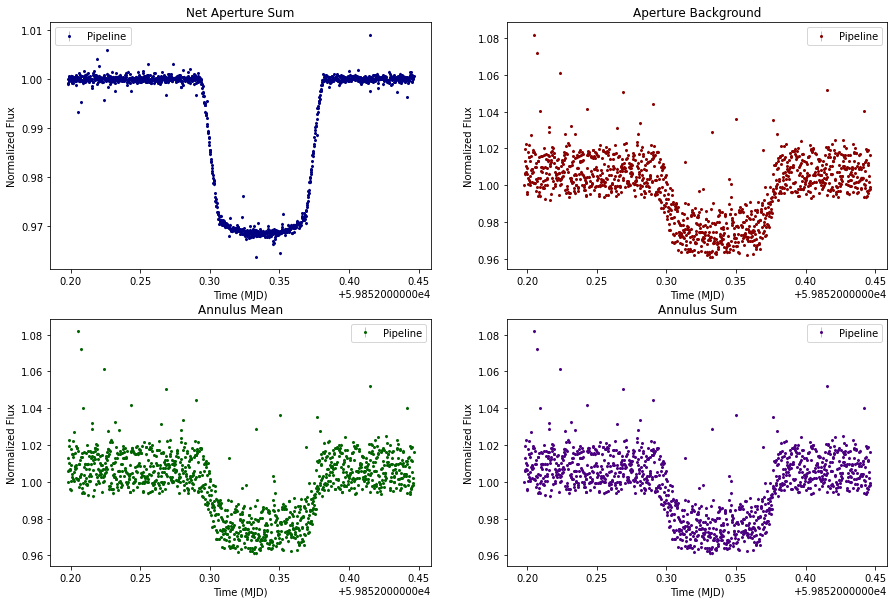

In [16]:
fig, axs = plt.subplots(2, 2,figsize=(15,10))

#JWST pipeline: net aperture
dat = ascii.read('/fenrirdata1/kg_data/pipeline_output/WASP80b_WLP4/303050_radii/WASP80b_WLP4_nrca3_level3_asn_phot.ecsv') #call the data 
normalized_net_aperture_sum_pipeline = dat['net_aperture_sum'].value/dat['net_aperture_sum'][0].value #normalized net aperture sum
std_net_aperture_sum_pipeline = np.std(normalized_net_aperture_sum_pipeline[0:20]) #calculated standard deviation
relative_error_net_aperture_sum_pipeline = (dat['net_aperture_sum_err'].value/dat['net_aperture_sum'].value)

#MAD: 
deviation = normalized_net_aperture_sum_pipeline[0:seg01_len] - np.median(normalized_net_aperture_sum_pipeline[0:seg01_len])
mad = np.median(np.abs(deviation))*1.48

print(style.BOLD+"Pipeline Calculated Net Aperture Sum MAD (ppm):"+style.END + " " +str(mad*10**6))
print(style.BOLD+"Pipeline Calculated Net Aperture Sum std (ppm):"+style.END + " " +str(std_net_aperture_sum_pipeline*10**6))
print(style.BOLD+"Median Relative Errors Net Aperture Sum (ppm):"+style.END + " " +str(np.median(relative_error_net_aperture_sum_pipeline)*10**6))
      
axs[0,0].errorbar(dat['MJD'],normalized_net_aperture_sum_pipeline,yerr=relative_error_net_aperture_sum_pipeline,color='navy',fmt='.',markersize=4,elinewidth=1,ecolor='silver',label='Pipeline')
axs[0,0].set_title("Net Aperture Sum")
axs[0,0].set_xlabel("Time (MJD)")
axs[0,0].set_ylabel("Normalized Flux")
axs[0,0].legend()

#JWST pipeline: aperature background
normalized_aperture__bkg_pipeline = dat['aperture_bkg'].value/dat['aperture_bkg'][0].value #normalized aperture bkg
std_aperture_bkg_pipeline = np.std(normalized_aperture__bkg_pipeline[0:20]) #calculated standard deviation
relative_error_aperture_bkg_pipeline = (dat['aperture_bkg_err'].value/dat['aperture_bkg'].value)

print(style.BOLD+"Pipeline Calculated Aperture Background std (ppm):"+style.END + " " +str(std_aperture_bkg_pipeline*10**6))
print(style.BOLD+"Median Relative Errors Aperture Background (ppm):"+style.END + " " +str(np.median(relative_error_aperture_bkg_pipeline)*10**6))

axs[0,1].errorbar(dat['MJD'],normalized_aperture__bkg_pipeline,yerr=relative_error_aperture_bkg_pipeline,color='darkred',fmt='.',markersize=4,elinewidth=1,ecolor='silver',label='Pipeline')
axs[0,1].set_title("Aperture Background")
axs[0,1].set_xlabel("Time (MJD)")
axs[0,1].set_ylabel("Normalized Flux")
axs[0,1].legend()


#JWST pipeline: annulus mean
normalized_annulus_mean_pipeline = dat['annulus_mean'].value/dat['annulus_mean'][0].value #normalized annulus mean
std_annulus_mean_pipeline = np.std(normalized_annulus_mean_pipeline[0:20]) #calculated standard deviation
relative_error_annulus_mean_pipeline = (dat['annulus_mean_err'].value/dat['annulus_mean'].value)

print(style.BOLD+"Pipeline Calculated Annulus Mean std (ppm):"+style.END + " " +str(std_annulus_mean_pipeline*10**6))
print(style.BOLD+"Median Relative Errors Annulus Mean (ppm):"+style.END + " " +str(np.median(relative_error_annulus_mean_pipeline)*10**6))

axs[1,0].errorbar(dat['MJD'],normalized_annulus_mean_pipeline,yerr=relative_error_annulus_mean_pipeline,color ='darkgreen',fmt='.',markersize=4,elinewidth=1,ecolor='silver',label='Pipeline')
axs[1,0].set_title("Annulus Mean")
axs[1,0].set_xlabel("Time (MJD)")
axs[1,0].set_ylabel("Normalized Flux")
axs[1,0].legend()

#JWST pipeline: annulus sum
normalized_annulus_sum_pipeline = dat['annulus_sum'].value/dat['annulus_sum'][0].value #normalized annulus sum
std_annulus_sum_pipeline = np.std(normalized_annulus_sum_pipeline[0:20]) #calculated standard deviation
relative_error_annulus_sum_pipeline = (dat['annulus_sum_err'].value/dat['annulus_sum'].value)

print(style.BOLD+"Pipeline Calculated Annulus Sum std (ppm):"+style.END + " " +str(std_annulus_sum_pipeline*10**6))
print(style.BOLD+"Median Relative Errors Annulus Sum (ppm):"+style.END + " " +str(np.median(relative_error_annulus_sum_pipeline)*10**6))

axs[1,1].errorbar(dat['MJD'],normalized_annulus_sum_pipeline,yerr=relative_error_annulus_sum_pipeline,color = 'indigo',fmt='.',markersize=4,elinewidth=1,ecolor='silver',label='Pipeline')
axs[1,1].set_title("Annulus Sum")
axs[1,1].set_xlabel("Time (MJD)")
axs[1,1].set_ylabel("Normalized Flux")
axs[1,1].legend()

#### $\textbf{External method: tshirt $\rightarrow$ (bkgGeometry = CircularAnnulus) }$

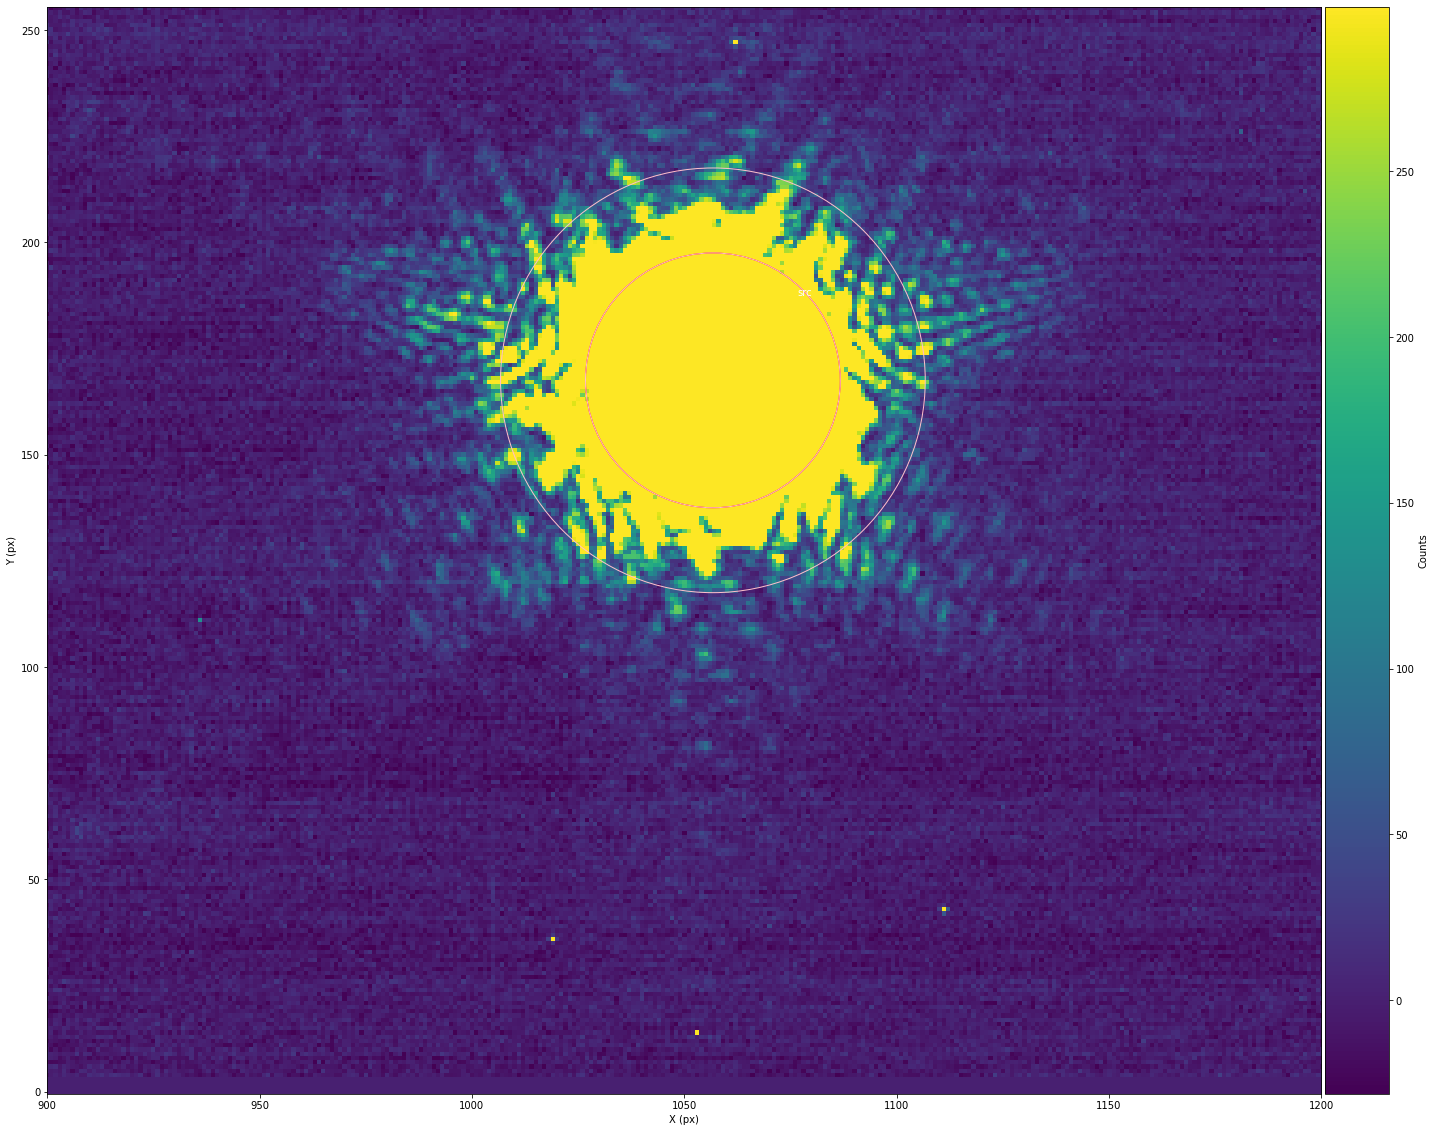

In [17]:
phot = phot_pipeline.phot(paramFile='/fenrirdata1/kg_data/pipeline_output/WASP80b_WLP4/WASP80b_WLP4_NRCA3_phot_pipeline.yaml') #create a photometric object
alteredParam = deepcopy(phot.param)
alteredParam['srcGeometry']='Circular'
alteredParam['bkgGeometry'] = 'CircularAnnulus' #Changing the outer radius
alteredParam['backEnd'] = 50 #Changing the outer radius
alteredParam['apRadius'] = 30 #Changing the source radius
alteredParam['backStart'] = 30 #Changing the inner radius

alteredParam['doCentering'] = True
alteredParam['srcNameShort'] = 'WASP80b_phot2' #provide a new name for centroid realignment

#Assignimg a object new phot2
phot2 = phot_pipeline.phot(directParam=alteredParam) #create new photometric object
#Assignimg a object phot
phot2.showStarChoices(showAps=True,showPlot=True,apColor='red',backColor='pink', figSize=(30,20),xLim=[900,1200]) #Plot the source and background subtraction area

In [18]:
phot2.get_allimg_cen(recenter=True,useMultiprocessing=True) #recenter the centroids each time. 
phot2.do_phot(useMultiprocessing=True) #extract the photometric data

  0%|                                                  | 0/1227 [00:00<?, ?it/s]2022-02-22 21:25:39,234 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:25:39,250 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:25:39,259 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:25:39,271 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/

2022-02-22 21:25:39,713 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:25:39,790 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

  1%|▎                                        | 11/1227 [00:00<01:14, 16.31it/s]2022-02-22 21:25:39,794 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:25:39,811 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/

2022-02-22 21:25:40,248 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:25:40,274 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:25:40,341 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:25:40,356 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may 

2022-02-22 21:25:40,788 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:25:40,796 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:25:40,825 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:25:40,889 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may 

2022-02-22 21:25:41,320 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:25:41,327 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:25:41,341 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:25:41,368 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may 

2022-02-22 21:25:41,925 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:25:41,960 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:25:41,995 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

  6%|██▎                                      | 71/1227 [00:03<00:48, 23.80it/s]2022-02-22 21:25:42,001 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/

2022-02-22 21:25:42,475 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

  7%|██▉                                      | 87/1227 [00:03<00:38, 29.89it/s]2022-02-22 21:25:42,505 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:25:42,511 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:25:42,545 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/

2022-02-22 21:25:43,015 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:25:43,032 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:25:43,058 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:25:43,073 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may 

2022-02-22 21:25:43,552 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:25:43,566 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:25:43,574 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

 10%|███▊                                    | 117/1227 [00:04<00:36, 30.57it/s]2022-02-22 21:25:43,597 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/

2022-02-22 21:25:44,088 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:25:44,117 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:25:44,118 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:25:44,131 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may 

2022-02-22 21:25:44,613 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:25:44,623 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:25:44,650 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:25:44,673 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may 

2022-02-22 21:25:45,131 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:25:45,164 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:25:45,167 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:25:45,184 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may 

 14%|█████▌                                  | 171/1227 [00:06<00:41, 25.47it/s]2022-02-22 21:25:45,667 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:25:45,676 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:25:45,717 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:25:45,724 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/

2022-02-22 21:25:46,206 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:25:46,214 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:25:46,244 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:25:46,260 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may 

2022-02-22 21:25:46,746 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:25:46,761 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

 16%|██████▌                                 | 201/1227 [00:07<00:39, 25.75it/s]2022-02-22 21:25:46,768 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:25:46,785 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/

2022-02-22 21:25:47,277 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:25:47,290 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:25:47,323 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:25:47,344 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may 

2022-02-22 21:25:47,861 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:25:47,891 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:25:47,929 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:25:47,942 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may 

2022-02-22 21:25:48,406 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:25:48,426 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

 20%|████████                                | 248/1227 [00:09<00:34, 28.50it/s]2022-02-22 21:25:48,438 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:25:48,483 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/

2022-02-22 21:25:48,959 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:25:48,962 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:25:48,987 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:25:48,991 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may 

2022-02-22 21:25:49,506 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:25:49,509 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:25:49,522 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:25:49,533 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may 

2022-02-22 21:25:50,067 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:25:50,071 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:25:50,082 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:25:50,083 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may 

2022-02-22 21:25:50,545 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

 25%|█████████▉                              | 304/1227 [00:11<00:34, 26.61it/s]2022-02-22 21:25:50,612 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:25:50,627 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:25:50,631 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/

2022-02-22 21:25:51,077 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:25:51,087 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:25:51,171 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:25:51,172 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may 

2022-02-22 21:25:51,650 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:25:51,666 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:25:51,753 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

 27%|██████████▉                             | 336/1227 [00:12<00:33, 26.71it/s]2022-02-22 21:25:51,778 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/

 29%|███████████▍                            | 350/1227 [00:13<00:28, 31.04it/s]2022-02-22 21:25:52,201 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:25:52,217 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:25:52,233 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:25:52,307 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/

2022-02-22 21:25:52,735 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:25:52,739 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:25:52,757 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:25:52,772 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may 

2022-02-22 21:25:53,360 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:25:53,436 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:25:53,467 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

 31%|████████████▍                           | 381/1227 [00:14<00:34, 24.87it/s]2022-02-22 21:25:53,495 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/

2022-02-22 21:25:54,004 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:25:54,026 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

 32%|████████████▉                           | 396/1227 [00:15<00:31, 26.71it/s]2022-02-22 21:25:54,067 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:25:54,084 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/

2022-02-22 21:25:54,479 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:25:54,561 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:25:54,591 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:25:54,604 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may 

2022-02-22 21:25:55,019 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:25:55,021 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:25:55,110 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

 35%|█████████████▉                          | 426/1227 [00:16<00:28, 28.51it/s]2022-02-22 21:25:55,147 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/

2022-02-22 21:25:55,574 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:25:55,578 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:25:55,586 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:25:55,661 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may 

2022-02-22 21:25:56,127 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:25:56,132 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:25:56,132 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:25:56,146 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may 

2022-02-22 21:25:56,669 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:25:56,671 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:25:56,687 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:25:56,687 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may 

2022-02-22 21:25:57,205 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

 39%|███████████████▋                        | 482/1227 [00:18<00:30, 24.80it/s]2022-02-22 21:25:57,217 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:25:57,229 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:25:57,231 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/

2022-02-22 21:25:57,773 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:25:57,774 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

 41%|████████████████▎                       | 499/1227 [00:18<00:26, 27.90it/s]2022-02-22 21:25:57,777 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:25:57,798 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/

2022-02-22 21:25:58,309 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:25:58,316 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:25:58,318 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:25:58,326 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may 

2022-02-22 21:25:58,853 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:25:58,858 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:25:58,868 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:25:58,869 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may 

2022-02-22 21:25:59,314 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:25:59,403 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:25:59,405 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

 44%|█████████████████▋                      | 543/1227 [00:20<00:25, 27.33it/s]2022-02-22 21:25:59,412 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/

 45%|██████████████████▏                     | 556/1227 [00:20<00:22, 29.18it/s]2022-02-22 21:25:59,846 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:25:59,875 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:25:59,933 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:25:59,957 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/

2022-02-22 21:26:00,375 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:26:00,388 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:26:00,415 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

 47%|██████████████████▋                     | 572/1227 [00:21<00:21, 29.87it/s]2022-02-22 21:26:00,488 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/

2022-02-22 21:26:00,915 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:26:00,925 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:26:00,926 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:26:00,961 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may 

 49%|███████████████████▌                    | 600/1227 [00:22<00:23, 27.22it/s]2022-02-22 21:26:01,467 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:26:01,479 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:26:01,481 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:26:01,592 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/

2022-02-22 21:26:02,012 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:26:02,015 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:26:02,024 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:26:02,027 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may 

2022-02-22 21:26:02,546 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:26:02,559 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:26:02,563 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:26:02,568 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may 

2022-02-22 21:26:03,061 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:26:03,099 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:26:03,112 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:26:03,116 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may 

2022-02-22 21:26:03,606 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:26:03,611 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

 54%|█████████████████████▍                  | 659/1227 [00:24<00:19, 28.45it/s]2022-02-22 21:26:03,649 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:26:03,655 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/

2022-02-22 21:26:04,169 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:26:04,174 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:26:04,196 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:26:04,216 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may 

2022-02-22 21:26:04,689 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:26:04,723 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:26:04,724 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

 56%|██████████████████████▍                 | 688/1227 [00:25<00:21, 25.07it/s]2022-02-22 21:26:04,731 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/

2022-02-22 21:26:05,235 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:26:05,237 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:26:05,276 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:26:05,287 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may 

2022-02-22 21:26:05,798 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:26:05,800 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:26:05,803 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:26:05,850 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may 

2022-02-22 21:26:06,329 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:26:06,340 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

 60%|███████████████████████▉                | 733/1227 [00:27<00:18, 26.86it/s]2022-02-22 21:26:06,349 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:26:06,352 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/

2022-02-22 21:26:06,842 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:26:06,852 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:26:06,882 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:26:06,889 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may 

2022-02-22 21:26:07,384 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:26:07,397 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:26:07,400 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:26:07,422 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may 

2022-02-22 21:26:07,897 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:26:07,899 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:26:07,909 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:26:07,942 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may 

2022-02-22 21:26:08,454 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:26:08,457 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:26:08,479 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:26:08,483 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may 

2022-02-22 21:26:08,966 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

 66%|██████████████████████████▏             | 805/1227 [00:29<00:15, 27.29it/s]2022-02-22 21:26:08,995 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:26:08,998 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:26:09,004 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/

2022-02-22 21:26:09,502 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:26:09,505 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

 67%|██████████████████████████▋             | 820/1227 [00:30<00:15, 26.28it/s]2022-02-22 21:26:09,537 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:26:09,544 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/

2022-02-22 21:26:10,006 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

 68%|███████████████████████████▏            | 835/1227 [00:31<00:13, 28.89it/s]2022-02-22 21:26:10,056 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:26:10,057 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:26:10,065 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/

2022-02-22 21:26:10,593 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:26:10,599 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

 69%|███████████████████████████▋            | 851/1227 [00:31<00:13, 27.64it/s]2022-02-22 21:26:10,608 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:26:10,638 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/

 70%|████████████████████████████▏           | 865/1227 [00:32<00:13, 25.87it/s]2022-02-22 21:26:11,174 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:26:11,181 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:26:11,195 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:26:11,198 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/

2022-02-22 21:26:11,671 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:26:11,702 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:26:11,717 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:26:11,734 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may 

2022-02-22 21:26:12,208 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

 73%|█████████████████████████████▏          | 894/1227 [00:33<00:11, 28.34it/s]2022-02-22 21:26:12,248 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:26:12,249 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:26:12,267 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/

 74%|█████████████████████████████▌          | 908/1227 [00:33<00:12, 26.38it/s]2022-02-22 21:26:12,758 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:26:12,790 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:26:12,803 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:26:12,807 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/

2022-02-22 21:26:13,297 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:26:13,311 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:26:13,346 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:26:13,358 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may 

2022-02-22 21:26:13,815 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

 76%|██████████████████████████████▌         | 937/1227 [00:34<00:11, 26.08it/s]2022-02-22 21:26:13,835 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:26:13,878 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:26:13,892 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/

2022-02-22 21:26:14,411 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:26:14,442 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:26:14,448 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:26:14,469 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may 

2022-02-22 21:26:14,954 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:26:14,975 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

 79%|███████████████████████████████▌        | 967/1227 [00:35<00:10, 24.42it/s]2022-02-22 21:26:14,983 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:26:14,995 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/

2022-02-22 21:26:15,474 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:26:15,492 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:26:15,495 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:26:15,505 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may 

2022-02-22 21:26:15,977 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:26:15,997 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:26:16,011 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:26:16,013 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may 

2022-02-22 21:26:16,510 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:26:16,522 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:26:16,532 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:26:16,532 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may 

2022-02-22 21:26:17,027 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:26:17,072 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:26:17,079 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:26:17,079 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may 

2022-02-22 21:26:17,545 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:26:17,569 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

 85%|█████████████████████████████████      | 1041/1227 [00:38<00:06, 29.98it/s]2022-02-22 21:26:17,611 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:26:17,624 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/

2022-02-22 21:26:18,086 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:26:18,089 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:26:18,123 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:26:18,161 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may 

2022-02-22 21:26:18,628 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:26:18,628 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:26:18,633 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:26:18,668 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may 

2022-02-22 21:26:19,170 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:26:19,179 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:26:19,184 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:26:19,207 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may 

 89%|██████████████████████████████████▊    | 1096/1227 [00:40<00:05, 25.89it/s]2022-02-22 21:26:19,709 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:26:19,720 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:26:19,728 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:26:19,738 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/

2022-02-22 21:26:20,198 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:26:20,240 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:26:20,269 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:26:20,273 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may 

2022-02-22 21:26:20,716 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:26:20,724 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:26:20,754 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

 92%|███████████████████████████████████▊   | 1127/1227 [00:41<00:03, 27.58it/s]2022-02-22 21:26:20,810 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/

2022-02-22 21:26:21,233 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:26:21,247 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:26:21,269 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:26:21,279 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may 

2022-02-22 21:26:21,761 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:26:21,765 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:26:21,783 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:26:21,791 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may 

2022-02-22 21:26:22,371 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:26:22,387 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:26:22,388 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:26:22,396 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may 

2022-02-22 21:26:22,898 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:26:22,922 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:26:22,924 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

 97%|█████████████████████████████████████▋ | 1187/1227 [00:43<00:01, 28.10it/s]2022-02-22 21:26:22,933 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/

2022-02-22 21:26:23,441 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:26:23,466 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:26:23,477 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:26:23,483 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may 

2022-02-22 21:26:23,960 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:26:23,987 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:26:24,028 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:26:24,034 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may 

2022-02-22 21:26:25,165 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/utils.py:94: UserWarning: Less than 0points accepted, returning flat line
  warnings.warn(warntext)

2022-02-22 21:26:25,169 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/utils.py:94: UserWarning: Less than 0points accepted, returning flat line
  warnings.warn(warntext)

2022-02-22 21:26:25,219 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/utils.py:94: UserWarning: Less than 0points accepted, returning flat line
  warnings.warn(warntext)

  1%|▎                                        | 11/1227 [00:00<00:47, 25.66it/s]2022-02-22 21:26:25,267 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/utils.py:94: UserWarning: Less than 0points accepted, returning flat line
  warnings.warn(warntex

2022-02-22 21:26:25,865 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/utils.py:94: UserWarning: Less than 0points accepted, returning flat line
  warnings.warn(warntext)

2022-02-22 21:26:25,875 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/utils.py:94: UserWarning: Less than 0points accepted, returning flat line
  warnings.warn(warntext)

2022-02-22 21:26:25,891 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/utils.py:94: UserWarning: Less than 0points accepted, returning flat line
  warnings.warn(warntext)

2022-02-22 21:26:25,898 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/utils.py:94: UserWarning: Less than 0points accepted, returning flat line
  warnings.warn(warntext)

2022-02-22 21:26:25,961 - stpipe - WARNING - /home/kglidic/miniconda3/envs/J

2022-02-22 21:26:26,665 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/utils.py:94: UserWarning: Less than 0points accepted, returning flat line
  warnings.warn(warntext)

2022-02-22 21:26:26,665 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/utils.py:94: UserWarning: Less than 0points accepted, returning flat line
  warnings.warn(warntext)

  6%|██▋                                      | 79/1227 [00:01<00:23, 49.73it/s]2022-02-22 21:26:26,695 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/utils.py:94: UserWarning: Less than 0points accepted, returning flat line
  warnings.warn(warntext)

2022-02-22 21:26:26,701 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/utils.py:94: UserWarning: Less than 0points accepted, returning flat line
  warnings.warn(warntex

2022-02-22 21:26:27,383 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/utils.py:94: UserWarning: Less than 0points accepted, returning flat line
  warnings.warn(warntext)

2022-02-22 21:26:27,389 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/utils.py:94: UserWarning: Less than 0points accepted, returning flat line
  warnings.warn(warntext)

2022-02-22 21:26:27,410 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/utils.py:94: UserWarning: Less than 0points accepted, returning flat line
  warnings.warn(warntext)

  9%|███▌                                    | 111/1227 [00:02<00:25, 43.52it/s]2022-02-22 21:26:27,476 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/utils.py:94: UserWarning: Less than 0points accepted, returning flat line
  warnings.warn(warntex

2022-02-22 21:26:28,153 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/utils.py:94: UserWarning: Less than 0points accepted, returning flat line
  warnings.warn(warntext)

 12%|████▋                                   | 145/1227 [00:03<00:24, 44.38it/s]2022-02-22 21:26:28,182 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/utils.py:94: UserWarning: Less than 0points accepted, returning flat line
  warnings.warn(warntext)

2022-02-22 21:26:28,185 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/utils.py:94: UserWarning: Less than 0points accepted, returning flat line
  warnings.warn(warntext)

2022-02-22 21:26:28,224 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/utils.py:94: UserWarning: Less than 0points accepted, returning flat line
  warnings.warn(warntex

 14%|█████▋                                  | 176/1227 [00:04<00:23, 44.53it/s]2022-02-22 21:26:28,874 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/utils.py:94: UserWarning: Less than 0points accepted, returning flat line
  warnings.warn(warntext)

2022-02-22 21:26:28,917 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/utils.py:94: UserWarning: Less than 0points accepted, returning flat line
  warnings.warn(warntext)

2022-02-22 21:26:28,947 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/utils.py:94: UserWarning: Less than 0points accepted, returning flat line
  warnings.warn(warntext)

2022-02-22 21:26:28,952 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/utils.py:94: UserWarning: Less than 0points accepted, returning flat line
  warnings.warn(warntex

2022-02-22 21:26:29,670 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/utils.py:94: UserWarning: Less than 0points accepted, returning flat line
  warnings.warn(warntext)

 17%|██████▉                                 | 212/1227 [00:04<00:23, 42.83it/s]2022-02-22 21:26:29,697 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/utils.py:94: UserWarning: Less than 0points accepted, returning flat line
  warnings.warn(warntext)

2022-02-22 21:26:29,710 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/utils.py:94: UserWarning: Less than 0points accepted, returning flat line
  warnings.warn(warntext)

2022-02-22 21:26:29,732 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/utils.py:94: UserWarning: Less than 0points accepted, returning flat line
  warnings.warn(warntex

 20%|███████▉                                | 243/1227 [00:05<00:22, 43.20it/s]2022-02-22 21:26:30,383 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/utils.py:94: UserWarning: Less than 0points accepted, returning flat line
  warnings.warn(warntext)

2022-02-22 21:26:30,388 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/utils.py:94: UserWarning: Less than 0points accepted, returning flat line
  warnings.warn(warntext)

2022-02-22 21:26:30,410 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/utils.py:94: UserWarning: Less than 0points accepted, returning flat line
  warnings.warn(warntext)

2022-02-22 21:26:30,429 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/utils.py:94: UserWarning: Less than 0points accepted, returning flat line
  warnings.warn(warntex

 23%|█████████▏                              | 281/1227 [00:06<00:19, 48.21it/s]2022-02-22 21:26:31,179 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/utils.py:94: UserWarning: Less than 0points accepted, returning flat line
  warnings.warn(warntext)

2022-02-22 21:26:31,209 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/utils.py:94: UserWarning: Less than 0points accepted, returning flat line
  warnings.warn(warntext)

2022-02-22 21:26:31,221 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/utils.py:94: UserWarning: Less than 0points accepted, returning flat line
  warnings.warn(warntext)

2022-02-22 21:26:31,259 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/utils.py:94: UserWarning: Less than 0points accepted, returning flat line
  warnings.warn(warntex

2022-02-22 21:26:31,863 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/utils.py:94: UserWarning: Less than 0points accepted, returning flat line
  warnings.warn(warntext)

 26%|██████████▏                             | 313/1227 [00:07<00:20, 45.55it/s]2022-02-22 21:26:31,888 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/utils.py:94: UserWarning: Less than 0points accepted, returning flat line
  warnings.warn(warntext)

2022-02-22 21:26:31,912 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/utils.py:94: UserWarning: Less than 0points accepted, returning flat line
  warnings.warn(warntext)

2022-02-22 21:26:31,918 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/utils.py:94: UserWarning: Less than 0points accepted, returning flat line
  warnings.warn(warntex

2022-02-22 21:26:32,624 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/utils.py:94: UserWarning: Less than 0points accepted, returning flat line
  warnings.warn(warntext)

2022-02-22 21:26:32,641 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/utils.py:94: UserWarning: Less than 0points accepted, returning flat line
  warnings.warn(warntext)

2022-02-22 21:26:32,644 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/utils.py:94: UserWarning: Less than 0points accepted, returning flat line
  warnings.warn(warntext)

2022-02-22 21:26:32,648 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/utils.py:94: UserWarning: Less than 0points accepted, returning flat line
  warnings.warn(warntext)

 28%|███████████▍                            | 349/1227 [00:07<00:19, 45.39i

2022-02-22 21:26:33,380 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/utils.py:94: UserWarning: Less than 0points accepted, returning flat line
  warnings.warn(warntext)

 31%|████████████▍                           | 382/1227 [00:08<00:18, 46.30it/s]2022-02-22 21:26:33,388 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/utils.py:94: UserWarning: Less than 0points accepted, returning flat line
  warnings.warn(warntext)

2022-02-22 21:26:33,423 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/utils.py:94: UserWarning: Less than 0points accepted, returning flat line
  warnings.warn(warntext)

2022-02-22 21:26:33,431 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/utils.py:94: UserWarning: Less than 0points accepted, returning flat line
  warnings.warn(warntex

 34%|█████████████▌                          | 415/1227 [00:09<00:17, 45.89it/s]2022-02-22 21:26:34,161 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/utils.py:94: UserWarning: Less than 0points accepted, returning flat line
  warnings.warn(warntext)

2022-02-22 21:26:34,174 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/utils.py:94: UserWarning: Less than 0points accepted, returning flat line
  warnings.warn(warntext)

2022-02-22 21:26:34,191 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/utils.py:94: UserWarning: Less than 0points accepted, returning flat line
  warnings.warn(warntext)

2022-02-22 21:26:34,208 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/utils.py:94: UserWarning: Less than 0points accepted, returning flat line
  warnings.warn(warntex

2022-02-22 21:26:34,843 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/utils.py:94: UserWarning: Less than 0points accepted, returning flat line
  warnings.warn(warntext)

2022-02-22 21:26:34,853 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/utils.py:94: UserWarning: Less than 0points accepted, returning flat line
  warnings.warn(warntext)

2022-02-22 21:26:34,893 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/utils.py:94: UserWarning: Less than 0points accepted, returning flat line
  warnings.warn(warntext)

2022-02-22 21:26:34,912 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/utils.py:94: UserWarning: Less than 0points accepted, returning flat line
  warnings.warn(warntext)

2022-02-22 21:26:34,926 - stpipe - WARNING - /home/kglidic/miniconda3/envs/J

2022-02-22 21:26:35,585 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/utils.py:94: UserWarning: Less than 0points accepted, returning flat line
  warnings.warn(warntext)

 39%|███████████████▋                        | 483/1227 [00:10<00:16, 45.31it/s]2022-02-22 21:26:35,596 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/utils.py:94: UserWarning: Less than 0points accepted, returning flat line
  warnings.warn(warntext)

2022-02-22 21:26:35,676 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/utils.py:94: UserWarning: Less than 0points accepted, returning flat line
  warnings.warn(warntext)

 40%|███████████████▉                        | 488/1227 [00:10<00:16, 45.89it/s]2022-02-22 21:26:35,698 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/utils.py:94: User

 42%|████████████████▉                       | 518/1227 [00:11<00:15, 45.72it/s]2022-02-22 21:26:36,353 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/utils.py:94: UserWarning: Less than 0points accepted, returning flat line
  warnings.warn(warntext)

2022-02-22 21:26:36,369 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/utils.py:94: UserWarning: Less than 0points accepted, returning flat line
  warnings.warn(warntext)

2022-02-22 21:26:36,369 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/utils.py:94: UserWarning: Less than 0points accepted, returning flat line
  warnings.warn(warntext)

2022-02-22 21:26:36,376 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/utils.py:94: UserWarning: Less than 0points accepted, returning flat line
  warnings.warn(warntex

2022-02-22 21:26:37,038 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/utils.py:94: UserWarning: Less than 0points accepted, returning flat line
  warnings.warn(warntext)

2022-02-22 21:26:37,116 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/utils.py:94: UserWarning: Less than 0points accepted, returning flat line
  warnings.warn(warntext)

2022-02-22 21:26:37,120 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/utils.py:94: UserWarning: Less than 0points accepted, returning flat line
  warnings.warn(warntext)

 45%|██████████████████                      | 554/1227 [00:12<00:13, 48.18it/s]2022-02-22 21:26:37,156 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/utils.py:94: UserWarning: Less than 0points accepted, returning flat line
  warnings.warn(warntex

2022-02-22 21:26:37,807 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/utils.py:94: UserWarning: Less than 0points accepted, returning flat line
  warnings.warn(warntext)

2022-02-22 21:26:37,827 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/utils.py:94: UserWarning: Less than 0points accepted, returning flat line
  warnings.warn(warntext)

 48%|███████████████████▏                    | 587/1227 [00:13<00:13, 47.41it/s]2022-02-22 21:26:37,871 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/utils.py:94: UserWarning: Less than 0points accepted, returning flat line
  warnings.warn(warntext)

2022-02-22 21:26:37,879 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/utils.py:94: UserWarning: Less than 0points accepted, returning flat line
  warnings.warn(warntex

2022-02-22 21:26:38,575 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/utils.py:94: UserWarning: Less than 0points accepted, returning flat line
  warnings.warn(warntext)

 50%|████████████████████▏                   | 619/1227 [00:13<00:14, 43.33it/s]2022-02-22 21:26:38,597 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/utils.py:94: UserWarning: Less than 0points accepted, returning flat line
  warnings.warn(warntext)

2022-02-22 21:26:38,656 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/utils.py:94: UserWarning: Less than 0points accepted, returning flat line
  warnings.warn(warntext)

2022-02-22 21:26:38,664 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/utils.py:94: UserWarning: Less than 0points accepted, returning flat line
  warnings.warn(warntex

 53%|█████████████████████▏                  | 649/1227 [00:14<00:13, 41.69it/s]2022-02-22 21:26:39,354 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/utils.py:94: UserWarning: Less than 0points accepted, returning flat line
  warnings.warn(warntext)

2022-02-22 21:26:39,371 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/utils.py:94: UserWarning: Less than 0points accepted, returning flat line
  warnings.warn(warntext)

 53%|█████████████████████▍                  | 656/1227 [00:14<00:11, 49.06it/s]2022-02-22 21:26:39,419 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/utils.py:94: UserWarning: Less than 0points accepted, returning flat line
  warnings.warn(warntext)

2022-02-22 21:26:39,439 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/utils.py:94: User

2022-02-22 21:26:40,035 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/utils.py:94: UserWarning: Less than 0points accepted, returning flat line
  warnings.warn(warntext)

 56%|██████████████████████▎                 | 686/1227 [00:15<00:11, 47.82it/s]2022-02-22 21:26:40,070 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/utils.py:94: UserWarning: Less than 0points accepted, returning flat line
  warnings.warn(warntext)

2022-02-22 21:26:40,114 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/utils.py:94: UserWarning: Less than 0points accepted, returning flat line
  warnings.warn(warntext)

2022-02-22 21:26:40,140 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/utils.py:94: UserWarning: Less than 0points accepted, returning flat line
  warnings.warn(warntex

2022-02-22 21:26:40,810 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/utils.py:94: UserWarning: Less than 0points accepted, returning flat line
  warnings.warn(warntext)

2022-02-22 21:26:40,824 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/utils.py:94: UserWarning: Less than 0points accepted, returning flat line
  warnings.warn(warntext)

 59%|███████████████████████▌                | 721/1227 [00:16<00:11, 45.44it/s]2022-02-22 21:26:40,886 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/utils.py:94: UserWarning: Less than 0points accepted, returning flat line
  warnings.warn(warntext)

2022-02-22 21:26:40,889 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/utils.py:94: UserWarning: Less than 0points accepted, returning flat line
  warnings.warn(warntex

2022-02-22 21:26:41,677 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/utils.py:94: UserWarning: Less than 0points accepted, returning flat line
  warnings.warn(warntext)

2022-02-22 21:26:41,679 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/utils.py:94: UserWarning: Less than 0points accepted, returning flat line
  warnings.warn(warntext)

2022-02-22 21:26:41,683 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/utils.py:94: UserWarning: Less than 0points accepted, returning flat line
  warnings.warn(warntext)

2022-02-22 21:26:41,691 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/utils.py:94: UserWarning: Less than 0points accepted, returning flat line
  warnings.warn(warntext)

 62%|████████████████████████▋               | 758/1227 [00:16<00:11, 41.64i

2022-02-22 21:26:42,356 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/utils.py:94: UserWarning: Less than 0points accepted, returning flat line
  warnings.warn(warntext)

2022-02-22 21:26:42,359 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/utils.py:94: UserWarning: Less than 0points accepted, returning flat line
  warnings.warn(warntext)

 64%|█████████████████████████▋              | 789/1227 [00:17<00:09, 46.18it/s]2022-02-22 21:26:42,437 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/utils.py:94: UserWarning: Less than 0points accepted, returning flat line
  warnings.warn(warntext)

2022-02-22 21:26:42,441 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/utils.py:94: UserWarning: Less than 0points accepted, returning flat line
  warnings.warn(warntex

 67%|██████████████████████████▊             | 821/1227 [00:18<00:08, 45.36it/s]2022-02-22 21:26:43,110 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/utils.py:94: UserWarning: Less than 0points accepted, returning flat line
  warnings.warn(warntext)

2022-02-22 21:26:43,135 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/utils.py:94: UserWarning: Less than 0points accepted, returning flat line
  warnings.warn(warntext)

2022-02-22 21:26:43,148 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/utils.py:94: UserWarning: Less than 0points accepted, returning flat line
  warnings.warn(warntext)

2022-02-22 21:26:43,154 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/utils.py:94: UserWarning: Less than 0points accepted, returning flat line
  warnings.warn(warntex

2022-02-22 21:26:43,828 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/utils.py:94: UserWarning: Less than 0points accepted, returning flat line
  warnings.warn(warntext)

 70%|███████████████████████████▉            | 856/1227 [00:19<00:08, 46.17it/s]2022-02-22 21:26:43,890 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/utils.py:94: UserWarning: Less than 0points accepted, returning flat line
  warnings.warn(warntext)

2022-02-22 21:26:43,915 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/utils.py:94: UserWarning: Less than 0points accepted, returning flat line
  warnings.warn(warntext)

2022-02-22 21:26:43,945 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/utils.py:94: UserWarning: Less than 0points accepted, returning flat line
  warnings.warn(warntex

2022-02-22 21:26:44,647 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/utils.py:94: UserWarning: Less than 0points accepted, returning flat line
  warnings.warn(warntext)

 73%|█████████████████████████████▏          | 894/1227 [00:19<00:07, 45.85it/s]2022-02-22 21:26:44,702 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/utils.py:94: UserWarning: Less than 0points accepted, returning flat line
  warnings.warn(warntext)

2022-02-22 21:26:44,705 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/utils.py:94: UserWarning: Less than 0points accepted, returning flat line
  warnings.warn(warntext)

2022-02-22 21:26:44,714 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/utils.py:94: UserWarning: Less than 0points accepted, returning flat line
  warnings.warn(warntex

 75%|██████████████████████████████          | 924/1227 [00:20<00:06, 45.11it/s]2022-02-22 21:26:45,365 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/utils.py:94: UserWarning: Less than 0points accepted, returning flat line
  warnings.warn(warntext)

2022-02-22 21:26:45,369 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/utils.py:94: UserWarning: Less than 0points accepted, returning flat line
  warnings.warn(warntext)

2022-02-22 21:26:45,374 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/utils.py:94: UserWarning: Less than 0points accepted, returning flat line
  warnings.warn(warntext)

2022-02-22 21:26:45,400 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/utils.py:94: UserWarning: Less than 0points accepted, returning flat line
  warnings.warn(warntex

2022-02-22 21:26:46,143 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/utils.py:94: UserWarning: Less than 0points accepted, returning flat line
  warnings.warn(warntext)

2022-02-22 21:26:46,150 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/utils.py:94: UserWarning: Less than 0points accepted, returning flat line
  warnings.warn(warntext)

2022-02-22 21:26:46,155 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/utils.py:94: UserWarning: Less than 0points accepted, returning flat line
  warnings.warn(warntext)

 78%|███████████████████████████████▎        | 960/1227 [00:21<00:06, 41.70it/s]2022-02-22 21:26:46,184 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/utils.py:94: UserWarning: Less than 0points accepted, returning flat line
  warnings.warn(warntex

2022-02-22 21:26:46,845 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/utils.py:94: UserWarning: Less than 0points accepted, returning flat line
  warnings.warn(warntext)

2022-02-22 21:26:46,893 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/utils.py:94: UserWarning: Less than 0points accepted, returning flat line
  warnings.warn(warntext)

 81%|████████████████████████████████▍       | 995/1227 [00:22<00:05, 43.69it/s]2022-02-22 21:26:46,932 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/utils.py:94: UserWarning: Less than 0points accepted, returning flat line
  warnings.warn(warntext)

2022-02-22 21:26:46,932 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/utils.py:94: UserWarning: Less than 0points accepted, returning flat line
  warnings.warn(warntex

2022-02-22 21:26:47,581 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/utils.py:94: UserWarning: Less than 0points accepted, returning flat line
  warnings.warn(warntext)

2022-02-22 21:26:47,599 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/utils.py:94: UserWarning: Less than 0points accepted, returning flat line
  warnings.warn(warntext)

2022-02-22 21:26:47,601 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/utils.py:94: UserWarning: Less than 0points accepted, returning flat line
  warnings.warn(warntext)

2022-02-22 21:26:47,676 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/utils.py:94: UserWarning: Less than 0points accepted, returning flat line
  warnings.warn(warntext)

 84%|████████████████████████████████▋      | 1030/1227 [00:22<00:04, 44.22i

2022-02-22 21:26:48,351 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/utils.py:94: UserWarning: Less than 0points accepted, returning flat line
  warnings.warn(warntext)

2022-02-22 21:26:48,357 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/utils.py:94: UserWarning: Less than 0points accepted, returning flat line
  warnings.warn(warntext)

2022-02-22 21:26:48,365 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/utils.py:94: UserWarning: Less than 0points accepted, returning flat line
  warnings.warn(warntext)

2022-02-22 21:26:48,369 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/utils.py:94: UserWarning: Less than 0points accepted, returning flat line
  warnings.warn(warntext)

 87%|█████████████████████████████████▊     | 1062/1227 [00:23<00:03, 46.38i

2022-02-22 21:26:49,081 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/utils.py:94: UserWarning: Less than 0points accepted, returning flat line
  warnings.warn(warntext)

2022-02-22 21:26:49,143 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/utils.py:94: UserWarning: Less than 0points accepted, returning flat line
  warnings.warn(warntext)

2022-02-22 21:26:49,161 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/utils.py:94: UserWarning: Less than 0points accepted, returning flat line
  warnings.warn(warntext)

 90%|██████████████████████████████████▉    | 1099/1227 [00:24<00:02, 45.79it/s]2022-02-22 21:26:49,193 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/utils.py:94: UserWarning: Less than 0points accepted, returning flat line
  warnings.warn(warntex

 92%|███████████████████████████████████▊   | 1127/1227 [00:25<00:02, 45.63it/s]2022-02-22 21:26:49,815 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/utils.py:94: UserWarning: Less than 0points accepted, returning flat line
  warnings.warn(warntext)

2022-02-22 21:26:49,859 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/utils.py:94: UserWarning: Less than 0points accepted, returning flat line
  warnings.warn(warntext)

2022-02-22 21:26:49,886 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/utils.py:94: UserWarning: Less than 0points accepted, returning flat line
  warnings.warn(warntext)

2022-02-22 21:26:49,923 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/utils.py:94: UserWarning: Less than 0points accepted, returning flat line
  warnings.warn(warntex

2022-02-22 21:26:50,617 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/utils.py:94: UserWarning: Less than 0points accepted, returning flat line
  warnings.warn(warntext)

2022-02-22 21:26:50,633 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/utils.py:94: UserWarning: Less than 0points accepted, returning flat line
  warnings.warn(warntext)

2022-02-22 21:26:50,635 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/utils.py:94: UserWarning: Less than 0points accepted, returning flat line
  warnings.warn(warntext)

 95%|████████████████████████████████████▉  | 1164/1227 [00:25<00:01, 44.06it/s]2022-02-22 21:26:50,730 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/utils.py:94: UserWarning: Less than 0points accepted, returning flat line
  warnings.warn(warntex

2022-02-22 21:26:51,387 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/utils.py:94: UserWarning: Less than 0points accepted, returning flat line
  warnings.warn(warntext)

 98%|██████████████████████████████████████ | 1199/1227 [00:26<00:00, 49.77it/s]2022-02-22 21:26:51,427 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/utils.py:94: UserWarning: Less than 0points accepted, returning flat line
  warnings.warn(warntext)

2022-02-22 21:26:51,432 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/utils.py:94: UserWarning: Less than 0points accepted, returning flat line
  warnings.warn(warntext)

2022-02-22 21:26:51,454 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/utils.py:94: UserWarning: Less than 0points accepted, returning flat line
  warnings.warn(warntex

Tshirt Calculated Net Aperture Sum MAD (ppm): 662.9473199611624
Tshirt Calculated Net Aperture Sum std (ppm): 604.1318732693674
Median Relative Errors Net Aperture Sum (ppm): 254.5071606835414


<ErrorbarContainer object of 3 artists>

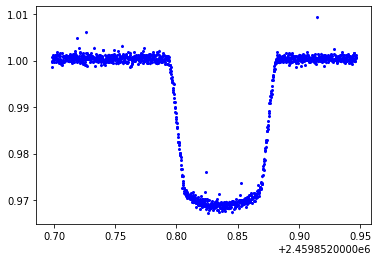

In [19]:
#Tshirt: net aperture
Flux2, Flux_error2 = phot2.get_tSeries() #The flux data and flux data errors
normalized_flux_tshirt2 = Flux2['Flux 0']/Flux2['Flux 0'][0] #normalized net aperture sum
std_tshirt2 = np.std(normalized_flux_tshirt2[0:20]) #calculated standard deviation
relative_error_tshirt2 = (Flux_error2['Error 0']/Flux2['Flux 0'])

#MAD: 
deviation = normalized_flux_tshirt2[0:seg01_len] - np.median(normalized_flux_tshirt2[0:seg01_len])
mad = np.median(np.abs(deviation))*1.48

print(style.BOLD+"Tshirt Calculated Net Aperture Sum MAD (ppm):"+style.END + " " +str(mad*10**6))
print(style.BOLD+"Tshirt Calculated Net Aperture Sum std (ppm):"+style.END + " " +str(std_tshirt2*10**6))
print(style.BOLD+"Median Relative Errors Net Aperture Sum (ppm):"+style.END + " " +str(np.median(relative_error_tshirt2)*10**6))

plt.errorbar(Flux2['Time (JD)'],normalized_flux_tshirt2,yerr=relative_error_tshirt2,fmt='b.',markersize=4,elinewidth=1,ecolor='silver')

## $\textbf{25-5-12 Radii}$

### $\textbf{TSO Photometry Reference File: Radii Parameters}$
The original radii parameters are: 
`radii': [{'pupil': 'WLP8',
   'radius': 50.0,
   'radius_inner': 60.0,
   'radius_outer': 70.0},
  {'pupil': 'ANY', 'radius': 3.0, 'radius_inner': 4.0, 'radius_outer': 5.0}]}`
  
The altered radii parameters are (to try the `pupil = CLEAR` parameters): 
   `radius: 25.0`,
   `radius_inner: 5.0`, and
   `radius_outer: 12.0`

In [30]:
original_tsophot=asdf.open("/fenrirdata1/kg_data/crds_cache/references/jwst/nircam/jwst_nircam_tsophot_0001.asdf") #the original tsophot reference file
original_tsophot.tree #print the original tsophot reference file

#adjust the radii parameters
original_tsophot.tree['radii'] = [{'pupil': 'WLP8',
   'radius': 50.0,
   'radius_inner': 60.0,
   'radius_outer': 70.0}, #For this particular data set (F444W), the outer radius limit is 62 due to edge effects on detector
  {'pupil': 'ANY', 'radius': 25.0, 'radius_inner': 5.0, 'radius_outer': 12.0}]
original_tsophot.write_to('adjusted_jwst_nircam_tsophot_0001.asdf')
adjusted_tsophot=asdf.open('adjusted_jwst_nircam_tsophot_0001.asdf') #the adjusted tsophot reference file
adjusted_tsophot.tree #print the adjusted tsophot reference file

2021-11-08 23:06:33,652 - stpipe - WARNING - /tmp/ipykernel_354363/2304070180.py:1: ResourceWarning: unclosed file <_io.BufferedReader name='/fenrirdata1/kg_data/crds_cache/references/jwst/nircam/jwst_nircam_tsophot_0001.asdf'>
  original_tsophot=asdf.open("/fenrirdata1/kg_data/crds_cache/references/jwst/nircam/jwst_nircam_tsophot_0001.asdf") #the original tsophot reference file

2021-11-08 23:06:33,696 - stpipe - WARNING - /tmp/ipykernel_354363/2304070180.py:11: ResourceWarning: unclosed file <_io.BufferedReader name='adjusted_jwst_nircam_tsophot_0001.asdf'>
  adjusted_tsophot=asdf.open('adjusted_jwst_nircam_tsophot_0001.asdf') #the adjusted tsophot reference file



{'asdf_library': {'author': 'Space Telescope Science Institute',
  'homepage': 'http://github.com/spacetelescope/asdf',
  'name': 'asdf',
  'version': '2.7.2'},
 'history': {'entries': [{'description': 'File created based on values of aperture radii for NIRCam that were specified as constants in tso_photometry_step.py.',
    'time': datetime.datetime(2018, 7, 13, 17, 20, 5)}],
  'extensions': [{'extension_class': 'asdf.extension.BuiltinExtension',
    'software': {'name': 'asdf', 'version': '2.7.2'}},
   {'extension_class': 'astropy.io.misc.asdf.extension.AstropyAsdfExtension',
    'software': {'name': 'astropy', 'version': '4.2.1'}},
   {'extension_class': 'astropy.io.misc.asdf.extension.AstropyExtension',
    'software': {'name': 'astropy', 'version': '4.2.1'}},
   {'extension_class': 'gwcs.extension.GWCSExtension',
    'software': {'name': 'gwcs', 'version': '0.16.1'}}]},
 'meta': {'author': 'NIRCam IDT; P. Hodge',
  'date': '2018-07-13T17:20:00',
  'description': 'aperture radii fo

In [31]:
#The file to use is the stage 3 association file defined above. 

# Instantiate the class. Do not provide a configuration file.
pipeline_stage3 = Tso3Pipeline()

pipeline_stage3.outlier_detection.skip = True
pipeline_stage3.tso_photometry.override_tsophot = 'adjusted_jwst_nircam_tsophot_0001.asdf' #use the modified tso_phot ref file

# Specify that you want results saved to a file
pipeline_stage3.save_results = True
pipeline_stage3.output_dir = '/fenrirdata1/kg_data/pipeline_output/WASP80b_WLP4/25512_radii/'

# Execute the pipeline using the run method
result_stage3 = pipeline_stage3.run(level3_asn)

2021-11-08 23:06:48,995 - stpipe.Tso3Pipeline - INFO - Tso3Pipeline instance created.
2021-11-08 23:06:49,004 - stpipe.Tso3Pipeline.outlier_detection - INFO - OutlierDetectionStep instance created.
2021-11-08 23:06:49,009 - stpipe.Tso3Pipeline.tso_photometry - INFO - TSOPhotometryStep instance created.
2021-11-08 23:06:49,015 - stpipe.Tso3Pipeline.extract_1d - INFO - Extract1dStep instance created.
2021-11-08 23:06:49,020 - stpipe.Tso3Pipeline.white_light - INFO - WhiteLightStep instance created.
2021-11-08 23:06:49,395 - stpipe.Tso3Pipeline - INFO - Step Tso3Pipeline running with args ('/fenrirdata1/kg_data/pipeline_output/WASP80b_WLP4/nrca3_level3_asn.json',).
2021-11-08 23:06:49,404 - stpipe.Tso3Pipeline - INFO - Step Tso3Pipeline parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': '/fenrirdata1/kg_data/pipeline_output/WASP80b_WLP4/25512_radii/', 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip

2021-11-08 23:08:32,572 - stpipe.Tso3Pipeline.outlier_detection - INFO - Step outlier_detection parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': 'outlier_detection', 'search_output_file': False, 'input_dir': '/fenrirdata1/kg_data/pipeline_output/WASP80b_WLP4', 'weight_type': 'ivm', 'pixfrac': 1.0, 'kernel': 'square', 'fillval': 'INDEF', 'nlow': 0, 'nhigh': 0, 'maskpt': 0.7, 'grow': 1, 'snr': '5.0 4.0', 'scale': '1.2 0.7', 'backg': 0.0, 'save_intermediate_results': False, 'resample_data': True, 'good_bits': '~DO_NOT_USE', 'scale_detection': False, 'allowed_memory': None}
2021-11-08 23:08:32,573 - stpipe.Tso3Pipeline.outlier_detection - INFO - Step skipped.
2021-11-08 23:08:32,672 - stpipe.Tso3Pipeline.outlier_detection - INFO - Step outlier_detection done
2021-11-08 23:08:46,005 - stpipe.Tso3Pipeline - INFO - Performing ou

In [24]:
#Import the stage 3 result file with all the data
with open('/fenrirdata1/kg_data/pipeline_output/WASP80b_WLP4/25512_radii/WASP80b_WLP4_nrca3_level3_asn_phot.ecsv', 'r') as file:
    reader = csv.reader(file)
    for row in reader:
        print(row)

['# %ECSV 0.9']
['# ---']
['# datatype:']
['# - {name: MJD', ' datatype: float64}']
['# - {name: aperture_sum', ' unit: Jy', ' datatype: float64}']
['# - {name: aperture_sum_err', ' unit: Jy', ' datatype: float64}']
['# - {name: annulus_sum', ' unit: Jy', ' datatype: float64}']
['# - {name: annulus_sum_err', ' unit: Jy', ' datatype: float64}']
['# - {name: annulus_mean', ' unit: Jy', ' datatype: float64}']
['# - {name: annulus_mean_err', ' unit: Jy', ' datatype: float64}']
['# - {name: aperture_bkg', ' unit: Jy', ' datatype: float64}']
['# - {name: aperture_bkg_err', ' unit: Jy', ' datatype: float64}']
['# - {name: net_aperture_sum', ' unit: Jy', ' datatype: float64}']
['# - {name: net_aperture_sum_err', ' unit: Jy', ' datatype: float64}']
['# meta: !!omap']
['# - {instrument: NIRCAM}']
['# - {detector: NRCA3}']
['# - {channel: SHORT}']
['# - {subarray: SUBGRISM256}']
['# - {filter: WLP4}']
['# - {pupil: CLEAR}']
['# - {target_name: UNKNOWN}']
['# - {xcenter: 1055.75}']
['# - {ycenter:

['59852.30214486146 0.2093031110561932 6.17621171979428e-05 0.024032124621635877 1.9629278083786732e-05 6.428288111821504e-05 5.250582582117758e-08 0.12621914192035652 0.00010309494791904797 0.08308396913583668 0.00012017956318444345']
['59852.302347488425 0.20943928588906674 6.177258163854428e-05 0.024080184787541314 1.963442982971594e-05 6.441143595804137e-05 5.251960608723114e-08 0.12647155875809513 0.00010312200540817196 0.08296772713097161 0.00012020815214324554']
['59852.3025501154 0.20913818149169516 6.174294839686905e-05 0.02405516669965383 1.963068464534396e-05 6.434451575041112e-05 5.2509588194700204e-08 0.1263401612376777 0.00010310233532218468 0.08279802025401747 0.00012017605096535102']
['59852.30275274236 0.20911695690565046 6.174856477623745e-05 0.024068568240327718 1.9637041261082867e-05 6.438036316962618e-05 5.2526591334467976e-08 0.12641054748071281 0.00010313572090904868 0.08270640942493765 0.00012020757954203376']
['59852.30295536933 0.2090568607227153 6.17410204031

Pipeline Calculated Net Aperture Sum MAD (ppm): 1146.6572308133527
Pipeline Calculated Net Aperture Sum std (ppm): 1207.1178535394927
Median Relative Errors Net Aperture Sum (ppm): 1438.0601000711963
Pipeline Calculated Aperture Background std (ppm): 1216.6621354834804
Median Relative Errors Aperture Background (ppm): 808.9208058367085
Pipeline Calculated Annulus Mean std (ppm): 1216.6621354835145
Median Relative Errors Annulus Mean (ppm): 808.9208058367086
Pipeline Calculated Annulus Sum std (ppm): 1216.6621354834747
Median Relative Errors Annulus Sum (ppm): 808.9208058367086


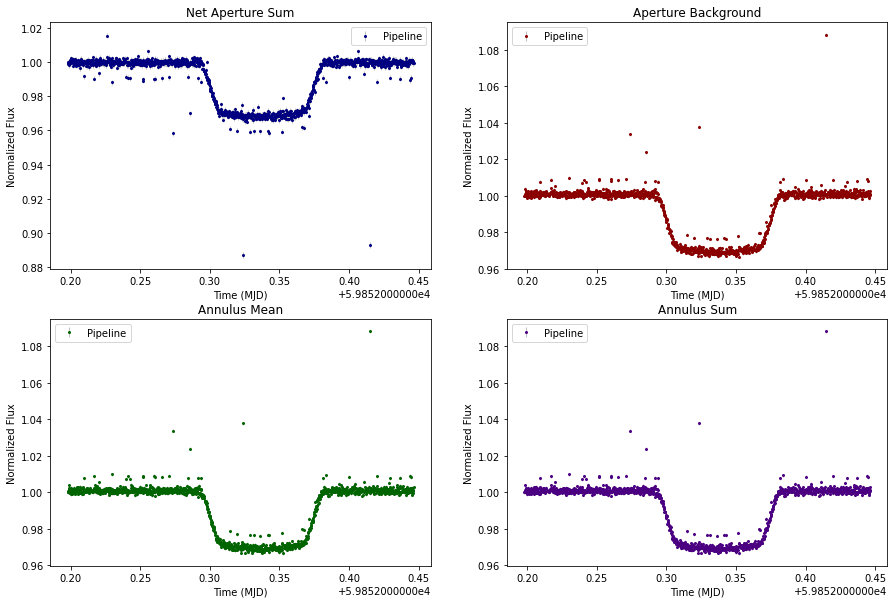

In [20]:
fig, axs = plt.subplots(2, 2,figsize=(15,10))

#JWST pipeline: net aperture
dat = ascii.read('/fenrirdata1/kg_data/pipeline_output/WASP80b_WLP4/25512_radii/WASP80b_WLP4_nrca3_level3_asn_phot.ecsv') #call the data 
normalized_net_aperture_sum_pipeline = dat['net_aperture_sum'].value/dat['net_aperture_sum'][0].value #normalized net aperture sum
std_net_aperture_sum_pipeline = np.std(normalized_net_aperture_sum_pipeline[0:20]) #calculated standard deviation
relative_error_net_aperture_sum_pipeline = (dat['net_aperture_sum_err'].value/dat['net_aperture_sum'].value)

#MAD: 
deviation = normalized_net_aperture_sum_pipeline[0:seg01_len] - np.median(normalized_net_aperture_sum_pipeline[0:seg01_len])
mad = np.median(np.abs(deviation))*1.48

print(style.BOLD+"Pipeline Calculated Net Aperture Sum MAD (ppm):"+style.END + " " +str(mad*10**6))
print(style.BOLD+"Pipeline Calculated Net Aperture Sum std (ppm):"+style.END + " " +str(std_net_aperture_sum_pipeline*10**6))
print(style.BOLD+"Median Relative Errors Net Aperture Sum (ppm):"+style.END + " " +str(np.median(relative_error_net_aperture_sum_pipeline)*10**6))

axs[0,0].errorbar(dat['MJD'],normalized_net_aperture_sum_pipeline,yerr=relative_error_net_aperture_sum_pipeline,color='navy',fmt='.',markersize=4,elinewidth=1,ecolor='silver',label='Pipeline')
axs[0,0].set_title("Net Aperture Sum")
axs[0,0].set_xlabel("Time (MJD)")
axs[0,0].set_ylabel("Normalized Flux")
axs[0,0].legend()

#JWST pipeline: aperature background
normalized_aperture__bkg_pipeline = dat['aperture_bkg'].value/dat['aperture_bkg'][0].value #normalized aperture bkg
std_aperture_bkg_pipeline = np.std(normalized_aperture__bkg_pipeline[0:20]) #calculated standard deviation
relative_error_aperture_bkg_pipeline = (dat['aperture_bkg_err'].value/dat['aperture_bkg'].value)

print(style.BOLD+"Pipeline Calculated Aperture Background std (ppm):"+style.END + " " +str(std_aperture_bkg_pipeline*10**6))
print(style.BOLD+"Median Relative Errors Aperture Background (ppm):"+style.END + " " +str(np.median(relative_error_aperture_bkg_pipeline)*10**6))

axs[0,1].errorbar(dat['MJD'],normalized_aperture__bkg_pipeline,yerr=relative_error_aperture_bkg_pipeline,color='darkred',fmt='.',markersize=4,elinewidth=1,ecolor='silver',label='Pipeline')
axs[0,1].set_title("Aperture Background")
axs[0,1].set_xlabel("Time (MJD)")
axs[0,1].set_ylabel("Normalized Flux")
axs[0,1].legend()


#JWST pipeline: annulus mean
normalized_annulus_mean_pipeline = dat['annulus_mean'].value/dat['annulus_mean'][0].value #normalized annulus mean
std_annulus_mean_pipeline = np.std(normalized_annulus_mean_pipeline[0:20]) #calculated standard deviation
relative_error_annulus_mean_pipeline = (dat['annulus_mean_err'].value/dat['annulus_mean'].value)

print(style.BOLD+"Pipeline Calculated Annulus Mean std (ppm):"+style.END + " " +str(std_annulus_mean_pipeline*10**6))
print(style.BOLD+"Median Relative Errors Annulus Mean (ppm):"+style.END + " " +str(np.median(relative_error_annulus_mean_pipeline)*10**6))

axs[1,0].errorbar(dat['MJD'],normalized_annulus_mean_pipeline,yerr=relative_error_annulus_mean_pipeline,color ='darkgreen',fmt='.',markersize=4,elinewidth=1,ecolor='silver',label='Pipeline')
axs[1,0].set_title("Annulus Mean")
axs[1,0].set_xlabel("Time (MJD)")
axs[1,0].set_ylabel("Normalized Flux")
axs[1,0].legend()

#JWST pipeline: annulus sum
normalized_annulus_sum_pipeline = dat['annulus_sum'].value/dat['annulus_sum'][0].value #normalized annulus sum
std_annulus_sum_pipeline = np.std(normalized_annulus_sum_pipeline[0:20]) #calculated standard deviation
relative_error_annulus_sum_pipeline = (dat['annulus_sum_err'].value/dat['annulus_sum'].value)

print(style.BOLD+"Pipeline Calculated Annulus Sum std (ppm):"+style.END + " " +str(std_annulus_sum_pipeline*10**6))
print(style.BOLD+"Median Relative Errors Annulus Sum (ppm):"+style.END + " " +str(np.median(relative_error_annulus_sum_pipeline)*10**6))

axs[1,1].errorbar(dat['MJD'],normalized_annulus_sum_pipeline,yerr=relative_error_annulus_sum_pipeline,color = 'indigo',fmt='.',markersize=4,elinewidth=1,ecolor='silver',label='Pipeline')
axs[1,1].set_title("Annulus Sum")
axs[1,1].set_xlabel("Time (MJD)")
axs[1,1].set_ylabel("Normalized Flux")
axs[1,1].legend()

#### $\textbf{External method: tshirt $\rightarrow$ (bkgGeometry = Circular Annulus) }$

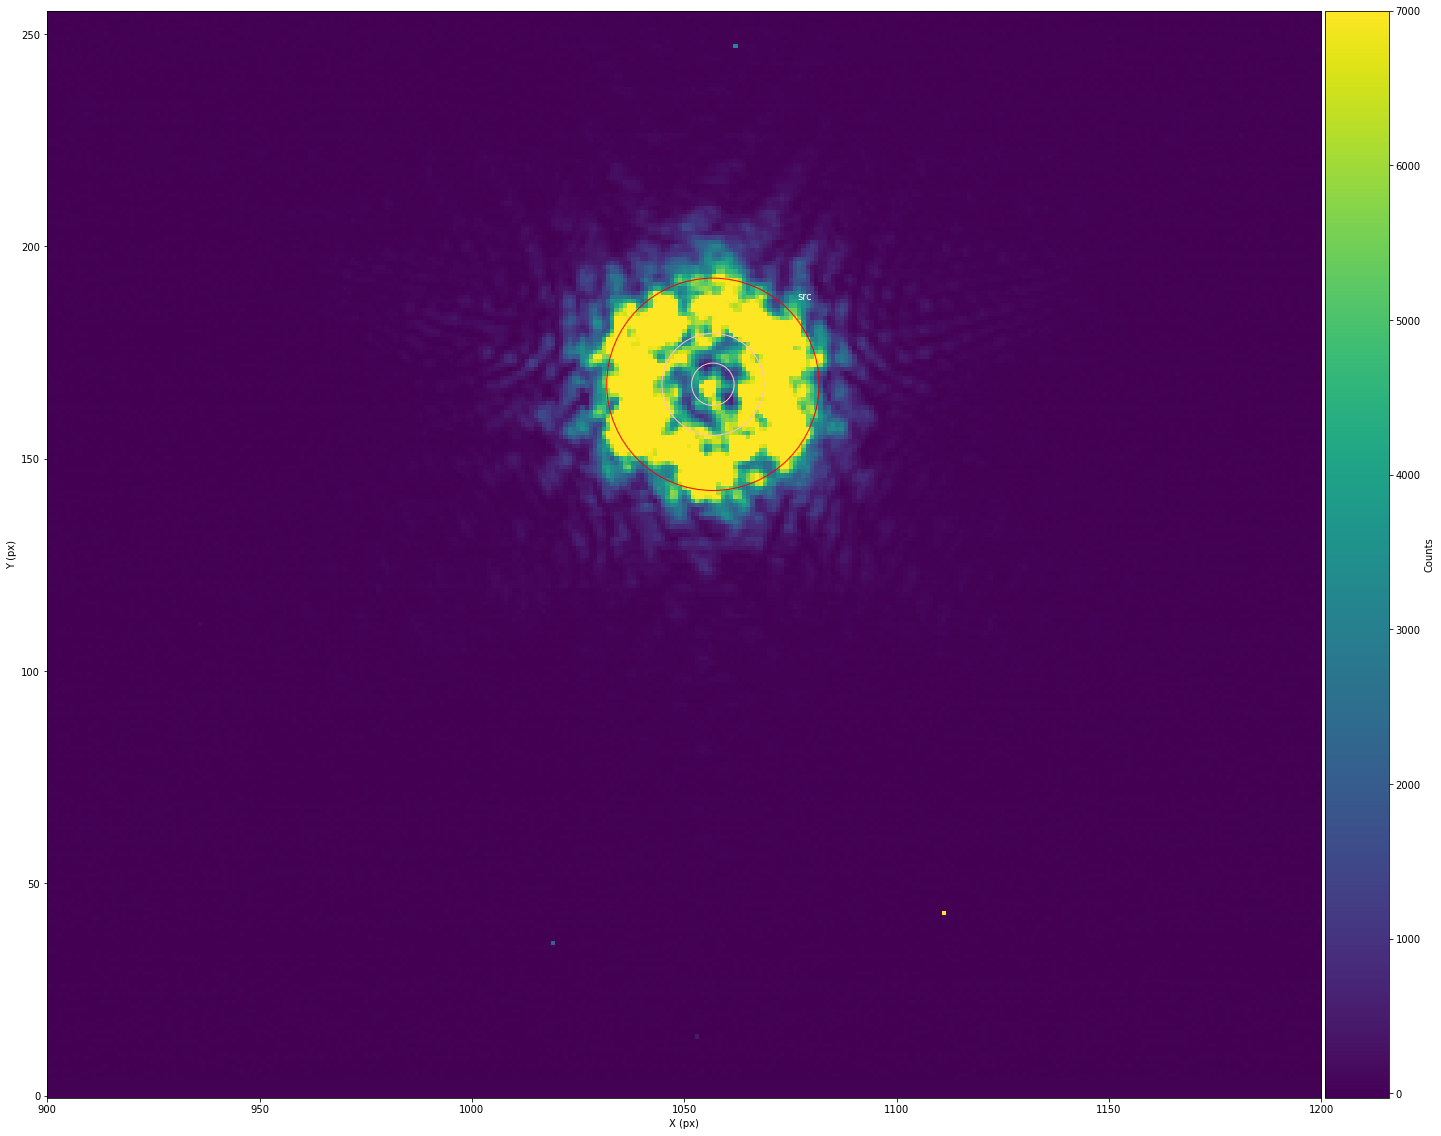

In [21]:
phot = phot_pipeline.phot(paramFile='/fenrirdata1/kg_data/pipeline_output/WASP80b_WLP4/WASP80b_WLP4_NRCA3_phot_pipeline.yaml') #create a photometric object

alteredParam = deepcopy(phot.param)
alteredParam['srcGeometry']='Circular'
alteredParam['bkgGeometry'] = 'CircularAnnulus'
alteredParam['backEnd'] = 12 #Changing the outer radius
alteredParam['apRadius'] = 25 #Changing the source radius
alteredParam['backStart'] = 5 #Changing the inner radius
alteredParam['bkgMethod'] = 'mean' #Due to the odd aperture configuration, we need to do mean background subtraction

alteredParam['doCentering'] = True
alteredParam['srcNameShort'] = 'WASP80b_phot3' #provide a new name for centroid realignment

#Assignimg a object new phot3
phot3 = phot_pipeline.phot(directParam=alteredParam) #create new photometric object

phot3.showStarChoices(showAps=True,showPlot=True,apColor='red',backColor='pink', figSize=(30,20),xLim=[900,1200], vmax=7000) #Plot the source and background subtraction area

In [22]:
phot3.get_allimg_cen(recenter=True,useMultiprocessing=True) #recenter the centroids each time. 
phot3.do_phot(useMultiprocessing=True) #extract the photometric data

  0%|                                                  | 0/1227 [00:00<?, ?it/s]2022-02-22 21:26:55,486 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:26:55,510 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:26:55,517 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:26:55,522 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/

2022-02-22 21:26:55,957 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:26:56,029 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

  1%|▎                                        | 11/1227 [00:00<01:13, 16.44it/s]2022-02-22 21:26:56,070 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:26:56,076 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/

2022-02-22 21:26:56,510 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:26:56,525 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:26:56,607 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:26:56,635 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may 

2022-02-22 21:26:57,064 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:26:57,070 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:26:57,096 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:26:57,153 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may 

2022-02-22 21:26:57,595 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:26:57,608 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:26:57,621 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

  5%|█▉                                       | 58/1227 [00:02<00:39, 29.93it/s]2022-02-22 21:26:57,673 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/

2022-02-22 21:26:58,212 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:26:58,213 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:26:58,264 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:26:58,308 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may 

2022-02-22 21:26:58,763 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:26:58,764 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:26:58,770 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:26:58,803 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may 

2022-02-22 21:26:59,339 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:26:59,341 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:26:59,342 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:26:59,343 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may 

2022-02-22 21:26:59,846 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:26:59,895 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:26:59,896 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

  9%|███▊                                    | 116/1227 [00:04<00:39, 28.26it/s]2022-02-22 21:26:59,905 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/

2022-02-22 21:27:00,412 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:27:00,425 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:27:00,452 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:27:00,472 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may 

2022-02-22 21:27:00,938 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:27:00,961 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:27:00,984 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:27:01,005 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may 

2022-02-22 21:27:01,501 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:27:01,509 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:27:01,527 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:27:01,534 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may 

2022-02-22 21:27:02,027 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:27:02,056 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:27:02,071 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:27:02,077 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may 

2022-02-22 21:27:02,531 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:27:02,587 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:27:02,619 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:27:02,633 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may 

2022-02-22 21:27:03,091 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:27:03,111 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:27:03,134 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

 16%|██████▌                                 | 201/1227 [00:07<00:41, 24.56it/s]2022-02-22 21:27:03,166 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/

 18%|███████                                 | 217/1227 [00:08<00:34, 29.67it/s]2022-02-22 21:27:03,632 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:27:03,636 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:27:03,692 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:27:03,717 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/

2022-02-22 21:27:04,217 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:27:04,224 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:27:04,295 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:27:04,318 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may 

2022-02-22 21:27:04,770 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:27:04,783 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:27:04,826 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:27:04,873 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may 

2022-02-22 21:27:05,402 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:27:05,453 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:27:05,466 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:27:05,488 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may 

2022-02-22 21:27:06,082 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:27:06,102 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:27:06,163 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:27:06,164 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may 

2022-02-22 21:27:06,799 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:27:06,832 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:27:06,847 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:27:06,851 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may 

2022-02-22 21:27:07,438 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

 25%|█████████▉                              | 304/1227 [00:12<00:40, 22.65it/s]2022-02-22 21:27:07,464 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:27:07,472 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:27:07,524 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/

2022-02-22 21:27:08,114 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:27:08,135 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:27:08,144 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:27:08,187 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may 

 27%|██████████▊                             | 333/1227 [00:13<00:42, 21.15it/s]2022-02-22 21:27:08,783 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:27:08,842 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:27:08,844 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:27:08,845 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/

2022-02-22 21:27:09,468 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:27:09,491 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:27:09,499 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:27:09,527 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may 

2022-02-22 21:27:10,100 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

 30%|███████████▊                            | 362/1227 [00:14<00:39, 21.91it/s]2022-02-22 21:27:10,150 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:27:10,157 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:27:10,184 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/

2022-02-22 21:27:10,944 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:27:10,950 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:27:10,956 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:27:10,996 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may 

2022-02-22 21:27:11,658 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:27:11,689 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

 32%|████████████▊                           | 393/1227 [00:16<00:45, 18.16it/s]2022-02-22 21:27:11,700 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:27:11,727 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/

 33%|█████████████▎                          | 410/1227 [00:17<00:32, 25.52it/s]2022-02-22 21:27:12,307 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:27:12,348 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:27:12,362 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:27:12,396 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/

2022-02-22 21:27:12,984 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:27:12,985 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

 34%|█████████████▋                          | 421/1227 [00:17<00:43, 18.36it/s]2022-02-22 21:27:12,996 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:27:13,015 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/

2022-02-22 21:27:13,568 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:27:13,631 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:27:13,643 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:27:13,686 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may 

2022-02-22 21:27:14,272 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:27:14,289 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:27:14,293 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:27:14,298 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may 

2022-02-22 21:27:14,918 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

 38%|███████████████▏                        | 466/1227 [00:19<00:34, 21.86it/s]2022-02-22 21:27:14,928 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:27:15,034 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:27:15,052 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/

 39%|███████████████▌                        | 479/1227 [00:20<00:37, 20.20it/s]2022-02-22 21:27:15,620 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:27:15,675 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:27:15,683 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:27:15,693 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/

2022-02-22 21:27:16,278 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:27:16,353 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:27:16,367 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:27:16,372 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may 

 42%|████████████████▋                       | 510/1227 [00:21<00:29, 23.96it/s]2022-02-22 21:27:16,939 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:27:16,954 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:27:16,991 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:27:17,012 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/

 43%|█████████████████                       | 525/1227 [00:22<00:28, 24.69it/s]2022-02-22 21:27:17,551 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:27:17,597 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:27:17,616 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:27:17,619 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/

2022-02-22 21:27:18,207 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:27:18,250 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:27:18,277 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:27:18,277 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may 

2022-02-22 21:27:18,871 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:27:18,908 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:27:18,926 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:27:18,930 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may 

2022-02-22 21:27:19,542 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:27:19,558 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

 46%|██████████████████▌                     | 568/1227 [00:24<00:29, 22.19it/s]2022-02-22 21:27:19,576 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:27:19,584 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/

2022-02-22 21:27:20,198 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

 47%|██████████████████▉                     | 582/1227 [00:24<00:29, 21.65it/s]2022-02-22 21:27:20,233 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:27:20,254 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:27:20,272 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/

2022-02-22 21:27:20,828 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:27:20,887 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

 49%|███████████████████▍                    | 598/1227 [00:25<00:26, 23.37it/s]2022-02-22 21:27:20,972 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:27:20,980 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/

 50%|███████████████████▉                    | 611/1227 [00:26<00:26, 22.90it/s]2022-02-22 21:27:21,505 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:27:21,560 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:27:21,596 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:27:21,598 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/

2022-02-22 21:27:22,162 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:27:22,171 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:27:22,190 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:27:22,224 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may 

2022-02-22 21:27:22,801 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

 52%|████████████████████▊                   | 640/1227 [00:27<00:27, 21.48it/s]2022-02-22 21:27:22,836 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:27:22,896 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:27:22,917 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/

 53%|█████████████████████▎                  | 655/1227 [00:28<00:25, 22.30it/s]2022-02-22 21:27:23,506 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:27:23,512 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:27:23,552 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:27:23,596 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/

2022-02-22 21:27:24,174 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:27:24,187 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:27:24,193 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

 55%|█████████████████████▊                  | 671/1227 [00:28<00:24, 22.80it/s]2022-02-22 21:27:24,254 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/

2022-02-22 21:27:24,878 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:27:24,889 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:27:24,910 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:27:24,948 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may 

2022-02-22 21:27:25,564 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:27:25,568 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:27:25,585 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:27:25,594 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may 

2022-02-22 21:27:26,285 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:27:26,290 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

 58%|███████████████████████▎                | 716/1227 [00:31<00:22, 23.08it/s]2022-02-22 21:27:26,296 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:27:26,297 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/

2022-02-22 21:27:26,903 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:27:26,904 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:27:26,938 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:27:27,008 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may 

2022-02-22 21:27:27,559 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:27:27,619 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

 61%|████████████████████████▎               | 746/1227 [00:32<00:19, 24.91it/s]2022-02-22 21:27:27,643 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:27:27,654 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/

2022-02-22 21:27:28,244 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:27:28,257 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

 62%|████████████████████████▊               | 760/1227 [00:33<00:19, 23.80it/s]2022-02-22 21:27:28,279 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:27:28,324 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/

2022-02-22 21:27:28,944 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:27:28,954 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

 63%|█████████████████████████▏              | 772/1227 [00:33<00:24, 18.84it/s]2022-02-22 21:27:28,970 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:27:28,971 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/

2022-02-22 21:27:29,618 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

 64%|█████████████████████████▋              | 789/1227 [00:34<00:18, 24.06it/s]2022-02-22 21:27:29,646 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:27:29,654 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:27:29,656 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/

2022-02-22 21:27:30,301 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

 65%|██████████████████████████▏             | 802/1227 [00:35<00:20, 20.48it/s]2022-02-22 21:27:30,304 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:27:30,340 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:27:30,371 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/

2022-02-22 21:27:30,968 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:27:30,968 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:27:30,994 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:27:31,018 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may 

 68%|███████████████████████████             | 832/1227 [00:36<00:16, 23.71it/s]2022-02-22 21:27:31,634 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:27:31,674 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:27:31,680 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:27:31,694 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/

2022-02-22 21:27:32,331 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:27:32,412 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:27:32,423 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

 69%|███████████████████████████▋            | 848/1227 [00:37<00:17, 21.59it/s]2022-02-22 21:27:32,431 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/

2022-02-22 21:27:33,072 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:27:33,136 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:27:33,198 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:27:33,205 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may 

2022-02-22 21:27:33,810 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

 71%|████████████████████████████▌           | 877/1227 [00:38<00:16, 21.34it/s]2022-02-22 21:27:33,827 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:27:33,840 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:27:33,851 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/

 73%|█████████████████████████████           | 890/1227 [00:39<00:15, 21.44it/s]2022-02-22 21:27:34,408 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:27:34,463 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:27:34,494 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:27:34,499 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/

2022-02-22 21:27:35,073 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:27:35,082 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

 74%|█████████████████████████████▌          | 907/1227 [00:39<00:12, 25.14it/s]2022-02-22 21:27:35,149 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:27:35,215 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/

2022-02-22 21:27:35,822 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:27:35,851 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:27:35,871 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:27:35,875 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may 

2022-02-22 21:27:36,479 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:27:36,483 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:27:36,484 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:27:36,546 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may 

 77%|██████████████████████████████▉         | 948/1227 [00:41<00:13, 20.36it/s]2022-02-22 21:27:37,189 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:27:37,262 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:27:37,272 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:27:37,285 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/

2022-02-22 21:27:37,858 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:27:37,892 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

 79%|███████████████████████████████▍        | 965/1227 [00:42<00:12, 21.12it/s]2022-02-22 21:27:37,901 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:27:37,912 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/

 80%|███████████████████████████████▉        | 979/1227 [00:43<00:10, 23.73it/s]2022-02-22 21:27:38,498 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:27:38,504 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:27:38,549 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:27:38,559 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/

2022-02-22 21:27:39,169 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

 81%|████████████████████████████████▍       | 994/1227 [00:43<00:10, 21.85it/s]2022-02-22 21:27:39,183 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:27:39,188 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:27:39,218 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/

2022-02-22 21:27:39,815 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:27:39,868 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:27:39,871 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

 82%|████████████████████████████████       | 1010/1227 [00:44<00:09, 23.78it/s]2022-02-22 21:27:39,891 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/

2022-02-22 21:27:40,458 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:27:40,518 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:27:40,541 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:27:40,552 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may 

2022-02-22 21:27:41,142 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:27:41,156 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

 85%|████████████████████████████████▉      | 1037/1227 [00:45<00:09, 20.21it/s]2022-02-22 21:27:41,165 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:27:41,179 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/

2022-02-22 21:27:41,792 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:27:41,805 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:27:41,819 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:27:41,897 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may 

2022-02-22 21:27:42,469 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:27:42,470 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:27:42,477 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:27:42,495 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may 

2022-02-22 21:27:43,123 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

 88%|██████████████████████████████████▎    | 1081/1227 [00:47<00:06, 21.31it/s]2022-02-22 21:27:43,155 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:27:43,167 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:27:43,172 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/

 89%|██████████████████████████████████▊    | 1094/1227 [00:48<00:06, 19.08it/s]2022-02-22 21:27:43,800 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:27:43,801 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:27:43,863 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:27:43,900 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/

2022-02-22 21:27:44,497 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:27:44,535 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:27:44,543 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:27:44,543 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may 

2022-02-22 21:27:45,180 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:27:45,189 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

 92%|███████████████████████████████████▋   | 1124/1227 [00:49<00:05, 19.38it/s]2022-02-22 21:27:45,200 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:27:45,207 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/

2022-02-22 21:27:45,847 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:27:45,851 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:27:45,858 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:27:45,859 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may 

2022-02-22 21:27:46,489 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:27:46,492 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:27:46,514 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:27:46,538 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may 

2022-02-22 21:27:47,158 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:27:47,198 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:27:47,219 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:27:47,223 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may 

2022-02-22 21:27:47,834 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:27:47,852 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:27:47,897 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:27:47,912 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may 

2022-02-22 21:27:48,541 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:27:48,557 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:27:48,560 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:27:48,563 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may 

2022-02-22 21:27:49,178 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

 99%|██████████████████████████████████████▍| 1210/1227 [00:53<00:00, 20.51it/s]2022-02-22 21:27:49,182 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:27:49,193 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/modeling/fitting.py:1166: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

2022-02-22 21:27:49,217 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/

Tshirt Calculated Net Aperture Sum MAD (ppm): 1234.1020594840945
Tshirt Calculated Net Aperture Sum std (ppm): 1257.2691610367633
Median Relative Errors Net Aperture Sum (ppm): 1305.0783566299142


<ErrorbarContainer object of 3 artists>

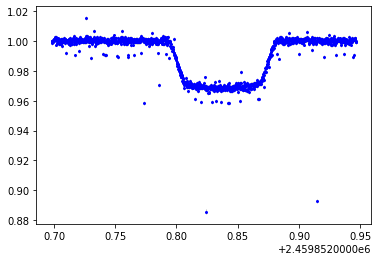

In [23]:
#Tshirt: net aperture
Flux3, Flux_error3 = phot3.get_tSeries() #The flux data and flux data errors
normalized_flux_tshirt3 = Flux3['Flux 0']/Flux3['Flux 0'][0] #normalized net aperture sum
std_tshirt3 = np.std(normalized_flux_tshirt3[0:20]) #calculated standard deviation
relative_error_tshirt3 = (Flux_error3['Error 0']/Flux3['Flux 0'])

#MAD: 
deviation = normalized_flux_tshirt3[0:seg01_len] - np.median(normalized_flux_tshirt3[0:seg01_len])
mad = np.median(np.abs(deviation))*1.48

print(style.BOLD+"Tshirt Calculated Net Aperture Sum MAD (ppm):"+style.END + " " +str(mad*10**6))
print(style.BOLD+"Tshirt Calculated Net Aperture Sum std (ppm):"+style.END + " " +str(std_tshirt3*10**6))
print(style.BOLD+"Median Relative Errors Net Aperture Sum (ppm):"+style.END + " " +str(np.median(relative_error_tshirt3)*10**6))

plt.errorbar(Flux3['Time (JD)'],normalized_flux_tshirt3,yerr=relative_error_tshirt3,fmt='b.',markersize=4,elinewidth=1,ecolor='silver')

# $\textbf{Light Curve Modeling}$
Modeling the best returned light curve from the photometry steps above. Here the best result is the 50-60-70 Radii values. 

Planet Parameters:
* per: 265062.4421 ## seconds, Triaud et al. 2015
* a: 12.63 ## a/r*, Triaud et al. 2015
* inc: 89.02 ## inclination, Triaud et al. 2015
* ecc: 0.  ## eccentricity, rounded to 0
* w: 90. ## longitude of periastron
* limb_model: "nonlinear" ## type of limb darkening model
* ld_u: [0.624,-0.198,0.059,-0.011] ## limb darkening parameters, ExoCTK 4 param law

In [37]:
def transit_model(x, rp, A, t0):
    '''
    Models transit light curve using Python package `batman` based on initial parameters stored in params_transit.
    
    Parameters
    ----------
    
    x: array
        Time in Julian days  
    rp: int
        Planet-to-star radius ratio
    A: int
        Baseline Normalization Factor
    t0: int
        Time of inferior conjunction
    '''

    params_transit = batman.TransitParams()                   #Object to store transit parameters
    
    params_transit.t0 = t0                                                       #time of inferior conjunction
    params_transit.per = 3.0678523391204                                                #orbital period
    params_transit.a = 12.63                                                      #semi-major axis (in units of stellar radii)
    params_transit.inc = 89.02                                                    #orbital inclination (in degrees)
    params_transit.ecc = 0                                                       #eccentricity
    params_transit.w = 90.0                                                      #longitude of periastron (in degrees)
    params_transit.limb_dark = "nonlinear"                                       #limb darkening model
    params_transit.u =  [0.624,-0.198,0.059,-0.011]                                 #limb darkening coefficients [u1, u2, u3, u4]
    
    params_transit.rp = rp                                    #Planet-to-star radius ratio - Will depend on function input
    
    #Modifying the time: Julian Date(x) - Initial Julian Date(x0) 
    x0 = np.min(x)
    m = batman.TransitModel(params_transit, x-x0)                #Initializes model
    
    flux = m.light_curve(params_transit)*A        #Calculate the light curve
    return flux

In [38]:
#Simple curve_fit model to determine the best planet-to-star radius ratio. 
popt, pcov = curve_fit(transit_model,Flux['Time (JD)'],normalized_flux_tshirt,sigma=relative_error_tshirt,p0=[0.08,1,0.124])

print("Optimized Planet-to-star radius ratio = " + str(popt[0]))
print("Optimized Baseline Normalization Factor = " + str(popt[1]))
print("Optimized Time of Inferior Conjunction = " + str(popt[2]))

Optimized Planet-to-star radius ratio = 0.17103017592390596
Optimized Baseline Normalization Factor = 1.0063350224744882
Optimized Time of Inferior Conjunction = 0.1391401074354491


Text(0, 0.5, 'Normalized Flux')

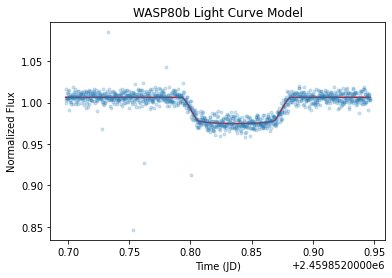

In [39]:
#plot the modeled light curves
modeled_flux =transit_model(Flux['Time (JD)'], *popt)
t = Flux['Time (JD)'] 

plt.plot(t,modeled_flux, color='red')
plt.plot(t,normalized_flux_tshirt,'.',alpha=0.2)
plt.title("WASP80b Light Curve Model")
plt.xlabel("Time (JD)")
plt.ylabel("Normalized Flux")

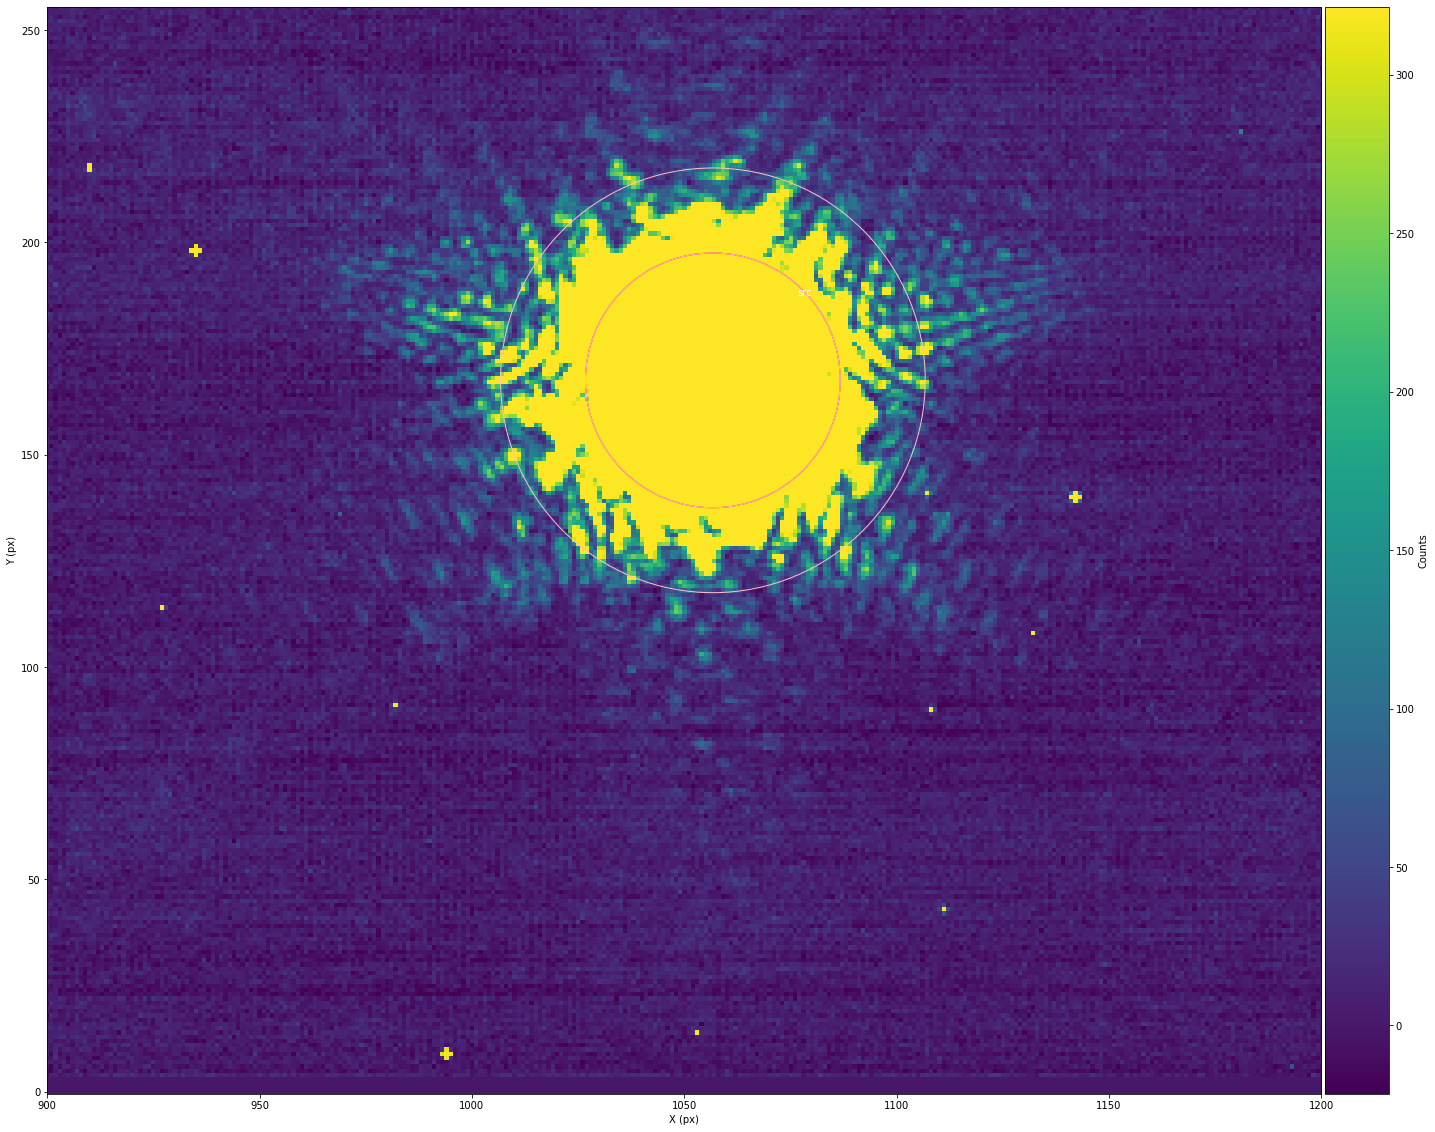

In [8]:
phot = phot_pipeline.phot(paramFile='/fenrirdata1/kg_data/pipeline_output/WASP80b_WLP4/WASP80b_WLP4_NRCA3_phot_pipeline.yaml') #create a photometric object
alteredParam = deepcopy(phot.param)
alteredParam['srcGeometry']='Circular'
alteredParam['bkgGeometry'] = 'CircularAnnulus' #Changing the outer radius
alteredParam['backEnd'] = 50 #Changing the outer radius
alteredParam['apRadius'] = 30 #Changing the source radius
alteredParam['backStart'] = 30 #Changing the inner radius
alteredParam['bkgMethod'] ='mean'
alteredParam['procFiles'] ='/fenrirdata1/kg_data/pipeline_output/WASP80b_WLP4/splintegrate/jw01185002001_01101_00001-seg001*.fits'

alteredParam['doCentering'] = True
alteredParam['srcNameShort'] = 'WASP80b_phot2' #provide a new name for centroid realignment

#Assignimg a object new phot2
phot2 = phot_pipeline.phot(directParam=alteredParam) #create new photometric object
#Assignimg a object phot
phot2.showStarChoices(showAps=True,showPlot=True,apColor='red',backColor='pink', figSize=(30,20),xLim=[900,1200]) #Plot the source and background subtraction area

In [12]:
obj = analysis.aperture_size_sweep(phot2,stepSize=2,srcRange=[5, 10],backRange=[5, 10])

2021-11-23 15:19:55,649 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:528: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  yStamp_proposed = np.array(onePos[1] + np.array([-1,1]) * boxsize,dtype=np.int)

2021-11-23 15:19:55,651 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:529: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. D

src: 5, back st: 5, back end: 7


100%|████████████████████████████████████████| 212/212 [00:00<00:00, 266.30it/s]
2021-11-23 15:19:57,068 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2021-11-23 15:19:57,098 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1527: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 5, back st: 5, back end: 9


100%|████████████████████████████████████████| 212/212 [00:00<00:00, 267.58it/s]
2021-11-23 15:19:58,216 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2021-11-23 15:19:58,247 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1527: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 5, back st: 7, back end: 9


100%|████████████████████████████████████████| 212/212 [00:00<00:00, 280.21it/s]
2021-11-23 15:19:59,333 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2021-11-23 15:19:59,365 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1527: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



src: 7, back st: 7, back end: 9


100%|████████████████████████████████████████| 212/212 [00:00<00:00, 277.87it/s]
2021-11-23 15:20:00,434 - stpipe - WARNING - /home/kglidic/.local/lib/python3.9/site-packages/astropy/io/fits/card.py:998: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

2021-11-23 15:20:00,475 - stpipe - WARNING - /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/tshirt/pipeline/phot_pipeline.py:1527: UserWarning: Only once source, so defaulting to refCorrect=False
  warnings.warn('Only once source, so defaulting to refCorrect=False')



Writing table to /home/kglidic/tshirt_data/tser_data/phot_aperture_optimization/aperture_opt_WASP80b_phot2_aperture_sizing_NRCA3_WASP80b_2022_09_30_src_5_10_step_2_back_5_10_step_2.csv
Min Stdev results:
src back_st back_end  stdev  theo_err mad_arr
--- ------- -------- ------- -------- -------
7.0     7.0      9.0 -2.0906  -1.3605 -0.8672


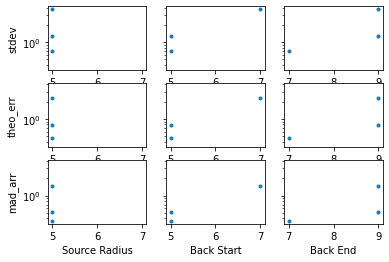

In [14]:
analysis.plot_apsizes('/home/kglidic/tshirt_data/tser_data/phot_aperture_optimization/aperture_opt_WASP80b_phot2_aperture_sizing_NRCA3_WASP80b_2022_09_30_src_5_10_step_2_back_5_10_step_2.csv')